# Importing Data

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
def fa(r,c,size):
    fig, ax = plt.subplots(r,c,figsize=size)
    return fig, ax

In [6]:
#WINDOWS
#data = r'D:\other studies\Quantium Case Comp 2024\QuantiumCaseComp2024\Risky Lending Data Set - revised.xlsx'
#MAC
data = r'/Users/mirazrai/Downloads/Uni/Quantium Case comp 2024/QuantiumCaseComp2024/Risky Lending Data Set - revised.xlsx'

customers = pd.read_excel(data, sheet_name="Customers",header=5, usecols=range(1,8))
applications = pd.read_excel(data, sheet_name="Applications",header=5, usecols=range(1,10))
campaigns = pd.read_excel(data, sheet_name="Campaigns",header=5, usecols=range(1,8))
clawbacks= pd.read_excel(data, sheet_name="Clawbacks",header=5, usecols=range(1,5))

# DATES ARE YEAR-MONTH-DAY

# Descriptive analysis
## Revenue measurement
Measure revenue by getting summing loan amounts from applications sheet that do not have a clawback within 12 months (keep track of the account ID).
- Track clawbacks, check which ones closed the account within 1 year (difference between open date and close date should be less than 1 year or 365/366 days depending on leap or non-leap year).
- Remove the corresponding rows from the applications column by matching Account IDs.
- Sum the remaining loan values and multiply by 4% to get revenue for risky lending. Can do this by year also for comparison of revenue over the 3 years.
- Calculate potential revenue lost due to the clawbacks (track the Account IDs we removed) and multiply 4% by the corresponding loan amounts to get the amount that was lost.

### Measuring total revenue from applications
First calculating 4% of loan value for each application then summing to find total revenue

<Axes: ylabel='Loan Amount'>

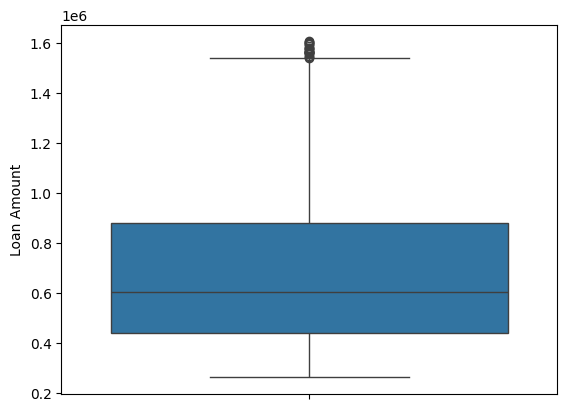

In [7]:
#checking for outliers and possible errors
sns.boxplot(data = applications['Loan Amount'])

<Axes: xlabel='Loan Amount', ylabel='Count'>

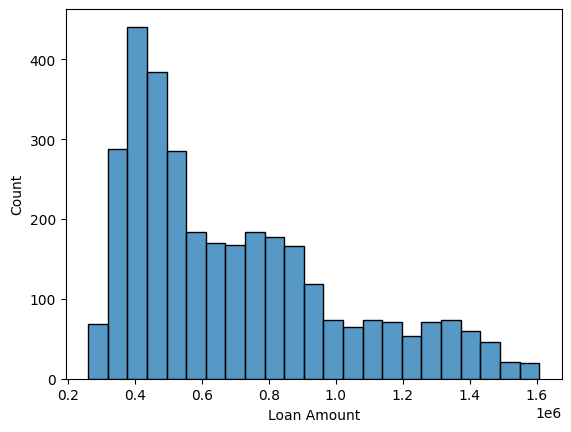

In [8]:
sns.histplot(data = applications['Loan Amount'])

In [9]:
total_revenue_from_applications = round(applications['Loan Amount'].sum()*0.04,2)
print('Total revenue from applications: $', total_revenue_from_applications)

Total revenue from applications: $ 91076973.44


In [10]:
#calculating revenue by year
yearly_revenue = {}
for year in [2020,2021,2022]:
    yearly_applications = applications[(applications['Application Date']<=pd.to_datetime(f'{year}/12/31'))*(applications['Application Date']>pd.to_datetime(f'{year-1}/12/31'))]
    yearly_revenue[year] = round(sum(yearly_applications['Loan Amount']*0.04),2)
    print('Application commission in year',year,' was $',yearly_revenue[year])
print('in total: $', sum(list(yearly_revenue.values())))

Application commission in year 2020  was $ 15026363.18
Application commission in year 2021  was $ 50552646.12
Application commission in year 2022  was $ 25497964.14
in total: $ 91076973.44


### Measuring loss from clawbacks
getting applications clawbacked, i.e closed within 1 year

In [11]:
clawbacks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376 entries, 0 to 375
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Account ID          376 non-null    int64         
 1   Account Open Date   376 non-null    datetime64[ns]
 2   Account Close Date  376 non-null    datetime64[ns]
 3   Close Reason        376 non-null    object        
dtypes: datetime64[ns](2), int64(1), object(1)
memory usage: 11.9+ KB


In [12]:
clawbacks

Account ID Account Open Date Account Close Date Close Reason
0         10040        2020-07-09         2021-01-29    REFINANCE
1         10230        2020-09-20         2020-12-10    REFINANCE
2         10393        2020-12-10         2021-04-16      DEFAULT
3         10331        2020-11-16         2021-05-20    REFINANCE
4         10326        2020-11-07         2021-03-15      DEFAULT
..          ...               ...                ...          ...
371       11923        2022-01-08         2022-04-30    REFINANCE
372       11961        2022-01-18         2022-04-20    REFINANCE
373       12343        2022-04-08         2022-05-20    REFINANCE
374       12334        2022-04-12         2022-06-04      DEFAULT
375       12257        2022-03-20         2022-05-26    REFINANCE

[376 rows x 4 columns]

In [13]:
clawbacks['open date + 12 mths'] = clawbacks['Account Open Date']+ pd.DateOffset(months=12)
clawbacks

Account ID Account Open Date Account Close Date Close Reason  \
0         10040        2020-07-09         2021-01-29    REFINANCE   
1         10230        2020-09-20         2020-12-10    REFINANCE   
2         10393        2020-12-10         2021-04-16      DEFAULT   
3         10331        2020-11-16         2021-05-20    REFINANCE   
4         10326        2020-11-07         2021-03-15      DEFAULT   
..          ...               ...                ...          ...   
371       11923        2022-01-08         2022-04-30    REFINANCE   
372       11961        2022-01-18         2022-04-20    REFINANCE   
373       12343        2022-04-08         2022-05-20    REFINANCE   
374       12334        2022-04-12         2022-06-04      DEFAULT   
375       12257        2022-03-20         2022-05-26    REFINANCE   

    open date + 12 mths  
0            2021-07-09  
1            2021-09-20  
2            2021-12-10  
3            2021-11-16  
4            2021-11-07  
..                  ...  
371          2023-01-08  
372          2023-01-18  
373          2023-04-08  
374          2023-04-12  
375          2023-03-20  

[376 rows x 5 columns]

In [14]:
sum(clawbacks['Account Close Date']<clawbacks['open date + 12 mths'])

376

All are closed within 12 mths

In [15]:
clawbacked_bool_array = applications["Account ID"].isin(clawbacks["Account ID"])
clawbacked_applications = applications[clawbacked_bool_array]
len(clawbacked_applications)

376

In [16]:
total_loss_from_clawbacks = round(clawbacked_applications['Loan Amount'].apply(func= lambda x: x * 0.04).sum(),2)
print('Total loss from clawbacked: $', total_loss_from_clawbacks)

Total loss from clawbacked: $ 10827669.69


In [17]:
#finding yearly clawbacked loss
yearly_clawbacked_losses = {}
for year in [2020,2021,2022]:
    yearly_clawbacks = clawbacks[(clawbacks['Account Close Date']<= pd.to_datetime(f'{year}/12/31'))*(clawbacks['Account Close Date']> pd.to_datetime(f'{year-1}/12/31'))]
    yearly_clawbacked_bool_array= applications["Account ID"].isin(yearly_clawbacks["Account ID"])
    yearly_clawbacked_applications = applications[yearly_clawbacked_bool_array]
    yearly_loss_from_clawbacks = round(yearly_clawbacked_applications['Loan Amount'].apply(func= lambda x: x * 0.04).sum(),2)
    yearly_clawbacked_losses[year] = yearly_loss_from_clawbacks
    print('Yearly loss from clawbacked: $', yearly_loss_from_clawbacks)
print('in total: $', sum(list(yearly_clawbacked_losses.values())))

Yearly loss from clawbacked: $ 696265.26
Yearly loss from clawbacked: $ 6074415.93
Yearly loss from clawbacked: $ 4056988.5
in total: $ 10827669.69


### Revenue - clawback loss:

In [18]:
print('Revenue - clawback loss: $',total_revenue_from_applications-total_loss_from_clawbacks)

Revenue - clawback loss: $ 80249303.75


In [19]:
#yearly revenue - clawback loss
for year in [2020,2021,2022]:
    print(f'revenue - loss for year {year}: $', yearly_revenue[year]-yearly_clawbacked_losses[year])


revenue - loss for year 2020: $ 14330097.92
revenue - loss for year 2021: $ 44478230.19
revenue - loss for year 2022: $ 21440975.64


# Investigating application opening amounts
- by month
- clawbacks by month (when they actually occur)

In [20]:
#splitting applications by year, then grouping by month and finding no. of applications per month
applications['Account Open Date'] = applications['Application Date'] + pd.DateOffset(weeks=3)
monthly_applications_size = {}
for year in [2020,2021,2022]:
    yearly_applications = applications.loc[(pd.to_datetime(f"{year-1}/12/31")<applications['Account Open Date'])*(applications['Account Open Date']<= pd.to_datetime(f"{year}/12/31"))]
    yearly_applications = yearly_applications.groupby(yearly_applications['Account Open Date'].dt.month)
    yearly_applications = yearly_applications.size()
    yearly_applications = pd.DataFrame(yearly_applications)
    yearly_applications['year'] = year
    monthly_applications_size[year] = yearly_applications

In [21]:
#concatenating all years tgt and preparing to plot
no_of_applications_by_month = pd.concat([monthly_applications_size[year] for year in [2020,2021,2022]])
no_of_applications_by_month['Month'] = np.arange(len(no_of_applications_by_month))
no_of_applications_by_month.rename(columns={0:'No. of Accounts opened'},inplace=True)
no_of_applications_by_month

no_of_applications_by_month

No. of Accounts opened  year  Month
Account Open Date                                     
7                                      47  2020      0
8                                      96  2020      1
9                                      98  2020      2
10                                     81  2020      3
11                                     88  2020      4
12                                     97  2020      5
1                                      87  2021      6
2                                      82  2021      7
3                                      96  2021      8
4                                      90  2021      9
5                                     163  2021     10
6                                     199  2021     11
7                                     176  2021     12
8                                     181  2021     13
9                                     154  2021     14
10                                    177  2021     15
11                                    156  2021     16
12                                    174  2021     17
1                                     176  2022     18
2                                     141  2022     19
3                                     175  2022     20
4                                     171  2022     21
5                                     180  2022     22
6                                     151  2022     23
7                                      25  2022     24

<Axes: xlabel='Month', ylabel='No. of Accounts opened'>

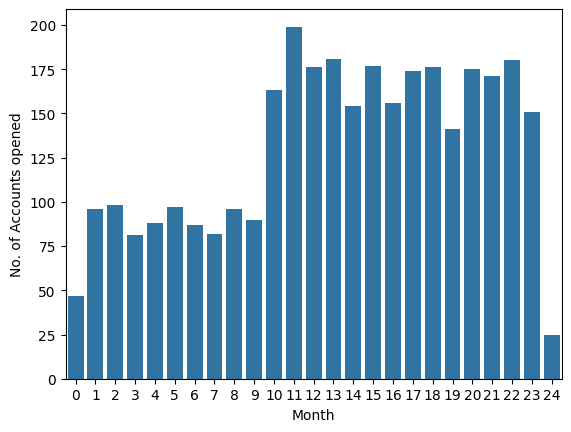

In [22]:
#plotting chart of account opening counts by month
sns.barplot(data=no_of_applications_by_month, x="Month", y = "No. of Accounts opened")

- Repeating for clawbacks (closure dates)

In [23]:
clawbacks

Account ID Account Open Date Account Close Date Close Reason  \
0         10040        2020-07-09         2021-01-29    REFINANCE   
1         10230        2020-09-20         2020-12-10    REFINANCE   
2         10393        2020-12-10         2021-04-16      DEFAULT   
3         10331        2020-11-16         2021-05-20    REFINANCE   
4         10326        2020-11-07         2021-03-15      DEFAULT   
..          ...               ...                ...          ...   
371       11923        2022-01-08         2022-04-30    REFINANCE   
372       11961        2022-01-18         2022-04-20    REFINANCE   
373       12343        2022-04-08         2022-05-20    REFINANCE   
374       12334        2022-04-12         2022-06-04      DEFAULT   
375       12257        2022-03-20         2022-05-26    REFINANCE   

    open date + 12 mths  
0            2021-07-09  
1            2021-09-20  
2            2021-12-10  
3            2021-11-16  
4            2021-11-07  
..                  ...  
371          2023-01-08  
372          2023-01-18  
373          2023-04-08  
374          2023-04-12  
375          2023-03-20  

[376 rows x 5 columns]

In [24]:
#splitting applications by year, then grouping by month and finding no. of applications per month
account_closure_monthly_size = {}
for year in [2020,2021,2022]:
    yearly_clawbacks = clawbacks.loc[(pd.to_datetime(f"{year-1}/12/31")<clawbacks['Account Close Date'])*(clawbacks['Account Close Date']<= pd.to_datetime(f"{year}/12/31"))]
    yearly_clawbacks = yearly_clawbacks.groupby(yearly_clawbacks['Account Close Date'].dt.month)
    yearly_clawbacks = yearly_clawbacks.size()
    yearly_clawbacks = pd.DataFrame(yearly_clawbacks)
    yearly_clawbacks['year'] = year
    account_closure_monthly_size[year] = yearly_clawbacks

#concatenating all years tgt and preparing to plot
no_of_clawbacks_by_month = pd.concat([account_closure_monthly_size[year] for year in [2020,2021,2022]])
no_of_clawbacks_by_month['Month'] = np.arange(len(no_of_clawbacks_by_month))
no_of_clawbacks_by_month.rename(columns={0:'No. of Accounts Closed'},inplace=True)
no_of_clawbacks_by_month

No. of Accounts Closed  year  Month
Account Close Date                                     
7                                        1  2020      0
8                                        3  2020      1
9                                        3  2020      2
10                                       8  2020      3
11                                       4  2020      4
12                                       6  2020      5
1                                        7  2021      6
2                                       10  2021      7
3                                        6  2021      8
4                                       10  2021      9
5                                       14  2021     10
6                                       15  2021     11
7                                       22  2021     12
8                                       26  2021     13
9                                       28  2021     14
10                                      25  2021     15
11                                      19  2021     16
12                                      32  2021     17
1                                       15  2022     18
2                                       23  2022     19
3                                       21  2022     20
4                                       33  2022     21
5                                       33  2022     22
6                                        9  2022     23
7                                        1  2022     24
9                                        2  2022     25

<Axes: xlabel='Month', ylabel='No. of Accounts Closed'>

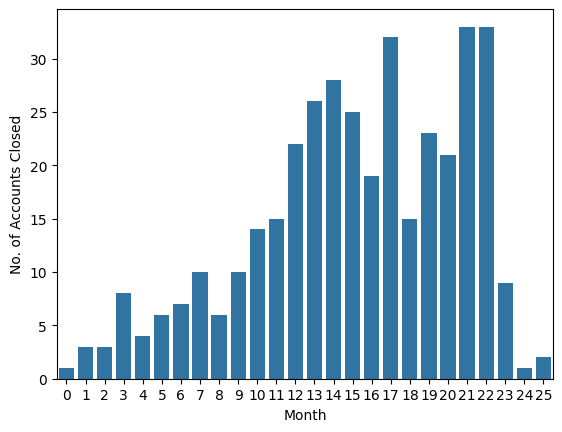

In [25]:
sns.barplot(data=no_of_clawbacks_by_month,x = 'Month', y="No. of Accounts Closed")

In [26]:
#plotting them together

In [27]:
accounts_opening_and_closing_by_month = pd.concat([no_of_applications_by_month['No. of Accounts opened'].reset_index().drop(columns={'Account Open Date'}), no_of_clawbacks_by_month['No. of Accounts Closed'].reset_index().drop(columns={'Account Close Date'})], axis= 1)
accounts_opening_and_closing_by_month.index.names = ['Month']
accounts_opening_and_closing_by_month = accounts_opening_and_closing_by_month.reset_index()
accounts_opening_and_closing_by_month

Month  No. of Accounts opened  No. of Accounts Closed
0       0                    47.0                       1
1       1                    96.0                       3
2       2                    98.0                       3
3       3                    81.0                       8
4       4                    88.0                       4
5       5                    97.0                       6
6       6                    87.0                       7
7       7                    82.0                      10
8       8                    96.0                       6
9       9                    90.0                      10
10     10                   163.0                      14
11     11                   199.0                      15
12     12                   176.0                      22
13     13                   181.0                      26
14     14                   154.0                      28
15     15                   177.0                      25
16     16                   156.0                      19
17     17                   174.0                      32
18     18                   176.0                      15
19     19                   141.0                      23
20     20                   175.0                      21
21     21                   171.0                      33
22     22                   180.0                      33
23     23                   151.0                       9
24     24                    25.0                       1
25     25                     NaN                       2

<Axes: xlabel='Month', ylabel='value'>

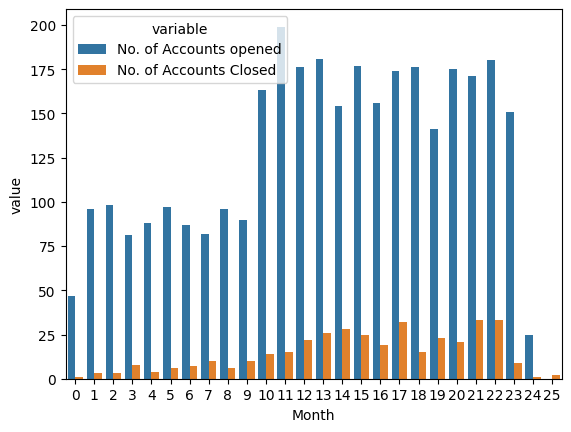

In [28]:
sns.barplot(data=accounts_opening_and_closing_by_month.melt(id_vars= 'Month'),x = 'Month', y = 'value', hue='variable') # need long format for hue parameter

Month 24 = June, Month 25 = sep

In [29]:
sorted_clawbacks = clawbacks.sort_values("Account Close Date")
sorted_clawbacks.tail()

Account ID Account Open Date Account Close Date Close Reason  \
145       11871        2021-12-12         2022-06-20    REFINANCE   
143       12064        2021-12-12         2022-06-21    REFINANCE   
146       11865        2021-12-01         2022-07-08    REFINANCE   
147       12151        2022-02-09         2022-09-11    REFINANCE   
144       12246        2022-02-18         2022-09-17    REFINANCE   

    open date + 12 mths  
145          2022-12-12  
143          2022-12-12  
146          2022-12-01  
147          2023-02-09  
144          2023-02-18

In [30]:
applications

Application ID Application Date  Customer ID  Loan Amount  Home Value  \
0              14088       2022-06-18        45307   1315392.00   1661798.4   
1              14076       2022-06-18        45102    524727.18    708042.0   
2              14096       2022-06-18        45238   1344389.00   1905753.0   
3              14082       2022-06-17        45239    773627.94    867008.0   
4              14080       2022-06-17        45227   1315458.00   1725310.8   
...              ...              ...          ...          ...         ...   
3256           10013       2020-06-16        35169   1025966.48   1457603.0   
3257           10010       2020-06-14        35152   1048110.00   1382829.0   
3258           10005       2020-06-11        35104    510090.02    621030.9   
3259           10003       2020-06-11        35013    407680.00    687440.0   
3260           10012       2020-06-10        35180    876168.00   1094644.0   

      Annual Income  Interest Rate (p.a.)  Term (months)  Account ID  \
0            122237                0.0399             40       13251   
1            189335                0.0389             25       13241   
2            144193                0.0395             30       13258   
3            158661                0.0407             15       13245   
4            137892                0.0379             40       13243   
...             ...                   ...            ...         ...   
3256         159032                0.0375             30       10010   
3257         122408                0.0394             30       10008   
3258          58440                0.0440             40       10004   
3259          72500                0.0397             25       10002   
3260         177635                0.0438             30       10009   

     Account Open Date  
0           2022-07-09  
1           2022-07-09  
2           2022-07-09  
3           2022-07-08  
4           2022-07-08  
...                ...  
3256        2020-07-07  
3257        2020-07-05  
3258        2020-07-02  
3259        2020-07-02  
3260        2020-07-01  

[3261 rows x 10 columns]

# snip off all data points from 23 month onwards 

In [31]:
sorted_applications = applications.sort_values("Account Open Date")
sorted_applications.tail(15)

Application ID Application Date  Customer ID  Loan Amount  Home Value  \
14           14081       2022-06-11        45231    807839.80    867300.0   
13           14036       2022-06-13        45067    447580.00    591973.2   
12           14067       2022-06-13        45323    311273.60    394828.0   
10           14093       2022-06-14        45137   1259368.00   1787100.0   
11           14091       2022-06-14        44872    807755.40    871470.0   
9            14092       2022-06-15        45021    304220.00    430360.0   
8            14041       2022-06-16        45093    337398.00    603709.0   
7            14037       2022-06-16        45217    761265.54    832356.0   
6            14071       2022-06-16        45123    756150.00    932940.0   
5            14094       2022-06-17        45144    598842.00    749943.0   
4            14080       2022-06-17        45227   1315458.00   1725310.8   
3            14082       2022-06-17        45239    773627.94    867008.0   
2            14096       2022-06-18        45238   1344389.00   1905753.0   
1            14076       2022-06-18        45102    524727.18    708042.0   
0            14088       2022-06-18        45307   1315392.00   1661798.4   

    Annual Income  Interest Rate (p.a.)  Term (months)  Account ID  \
14         196519                0.0473             30       13244   
13         208096                0.0435             15       13211   
12         225161                0.0460             25       13232   
10         137540                0.0404             30       13255   
11         156494                0.0424             30       13253   
9          219319                0.0452             15       13254   
8          250398                0.0431             25       13216   
7          198959                0.0475             25       13212   
6          150779                0.0421             30       13236   
5          165113                0.0408             15       13256   
4          137892                0.0379             40       13243   
3          158661                0.0407             15       13245   
2          144193                0.0395             30       13258   
1          189335                0.0389             25       13241   
0          122237                0.0399             40       13251   

   Account Open Date  
14        2022-07-02  
13        2022-07-04  
12        2022-07-04  
10        2022-07-05  
11        2022-07-05  
9         2022-07-06  
8         2022-07-07  
7         2022-07-07  
6         2022-07-07  
5         2022-07-08  
4         2022-07-08  
3         2022-07-08  
2         2022-07-09  
1         2022-07-09  
0         2022-07-09

In [32]:
applications[applications['Account Open Date'] == pd.to_datetime("2020/6/20")]

Empty DataFrame
Columns: [Application ID, Application Date, Customer ID, Loan Amount, Home Value, Annual Income, Interest Rate (p.a.), Term (months), Account ID, Account Open Date]
Index: []

# Creating a master df

In [33]:
sum(applications['Customer ID'].duplicated())

0

No customer has multiple applications

In [34]:
#adding customers and applications data together
df = pd.merge(customers, applications, on='Customer ID')
#adding campaign they signed up with
df = pd.merge(df, campaigns, on="Campaign ID", how='outer')
#adding clawbacks data
df['Clawbacked'] = df['Account ID'].isin(clawbacks['Account ID'])
df = pd.merge(df, clawbacks, on='Account ID', how='outer')

In [35]:
#getting rid of NaN values
df = df.fillna(0)

In [36]:
df.columns

Index(['Customer ID', 'Campaign ID', 'Contact Date', 'DOB', 'Q  Factor 1',
       'Q Factor 2', 'Q Factor 3', 'Application ID', 'Application Date',
       'Loan Amount', 'Home Value', 'Annual Income', 'Interest Rate (p.a.)',
       'Term (months)', 'Account ID', 'Account Open Date_x', 'Campaign Name',
       'Campaign Start', 'Campaign End', 'Campaign Offer',
       'Administration Expense', 'Service Expense', 'Clawbacked',
       'Account Open Date_y', 'Account Close Date', 'Close Reason',
       'open date + 12 mths'],
      dtype='object')

In [37]:
df.rename(columns={'Q  Factor 1': 'Q Factor 1'}, inplace=True)

# Checking relationship between Q factors and no. of clawbacks

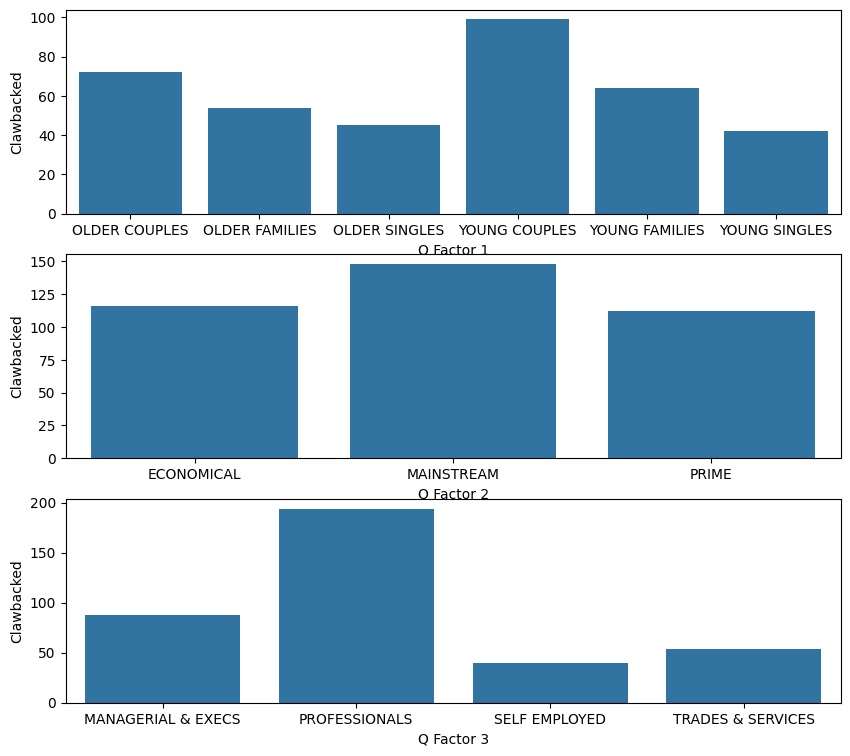

In [38]:
fig, ax = plt.subplots(3,1, figsize = (10,9))
for i in [1,2,3]:
    data = df.groupby(f'Q Factor {i}')['Clawbacked'].sum().reset_index()
    sns.barplot(data, ax = ax[i-1], x= f"Q Factor {i}", y = 'Clawbacked')

## Relationship between clawbacks and combination of (incl Q factor)
- Cumulative frequency graph

In [39]:
df['Clawbacked'] = df['Clawbacked'].astype(int)

In [40]:
df[['Loan Amount', 'Clawbacked', 'Q Factor 1']]

Loan Amount  Clawbacked      Q Factor 1
0       687344.00           0   OLDER COUPLES
1       407680.00           0   YOUNG SINGLES
2       755609.24           1  YOUNG FAMILIES
3       510090.02           1   YOUNG SINGLES
4       888404.88           0   YOUNG COUPLES
...           ...         ...             ...
3256    310837.17           0  OLDER FAMILIES
3257   1344389.00           0   YOUNG COUPLES
3258   1422840.00           0   YOUNG COUPLES
3259    386413.20           0  OLDER FAMILIES
3260    422407.35           0   OLDER COUPLES

[3261 rows x 3 columns]

In [41]:
# Function to plot cumulative frequency of clawbacks
def cumfreq_graph(x, variable, ax = False):
    '''Plots the cumulative frequency of the clawbacks with respect to `x` differentiated between `variable`'''
    cumfreq_df = df[[x, 'Clawbacked', variable]].sort_values(x)
    cumfreq_df['Cumulative Frequency'] = cumfreq_df.groupby(variable)['Clawbacked'].cumsum()
    g = sns.lineplot(cumfreq_df, x = x, y = 'Cumulative Frequency', hue=variable)
    if ax:
        g = sns.lineplot(cumfreq_df, x = x, y = 'Cumulative Frequency', hue=variable,ax = ax)
    return g

<Axes: xlabel='Loan Amount', ylabel='Cumulative Frequency'>

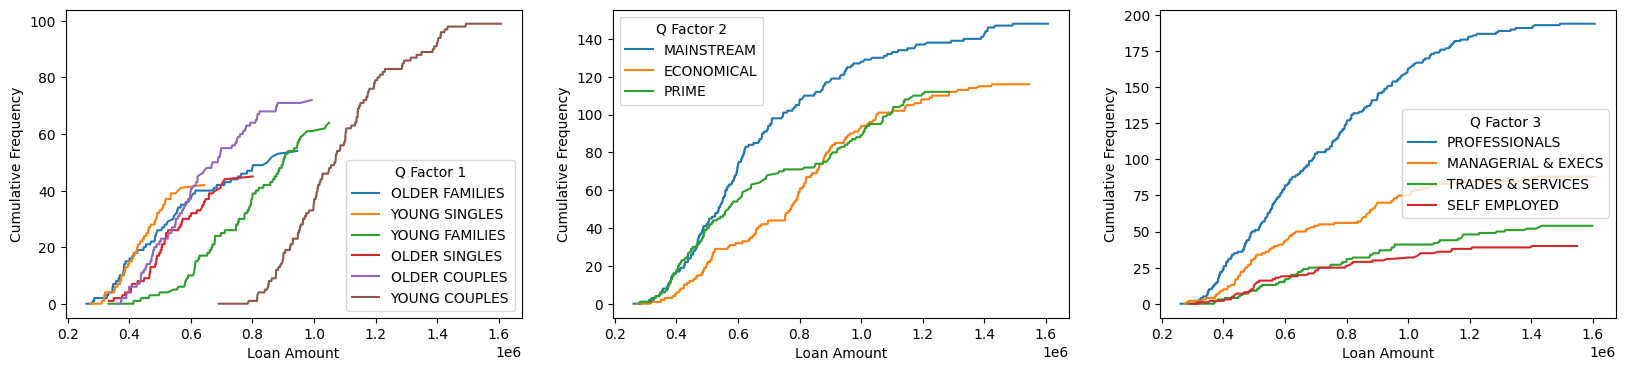

In [42]:
#plotting cumulative frequency of clawbacks to loan amounts, differentiating by Q factors

fig, ax = plt.subplots(1,3, figsize = (20,4))
for i in range(3):
    cumfreq_df = df[['Loan Amount', 'Clawbacked', f'Q Factor {i+1}']].sort_values('Loan Amount')
    cumfreq_df['Cumulative Frequency'] = cumfreq_df.groupby(f'Q Factor {i+1}')['Clawbacked'].cumsum()
    fig = sns.lineplot(cumfreq_df, x = 'Loan Amount', y = 'Cumulative Frequency', hue=f'Q Factor {i+1}', ax = ax[i])
fig

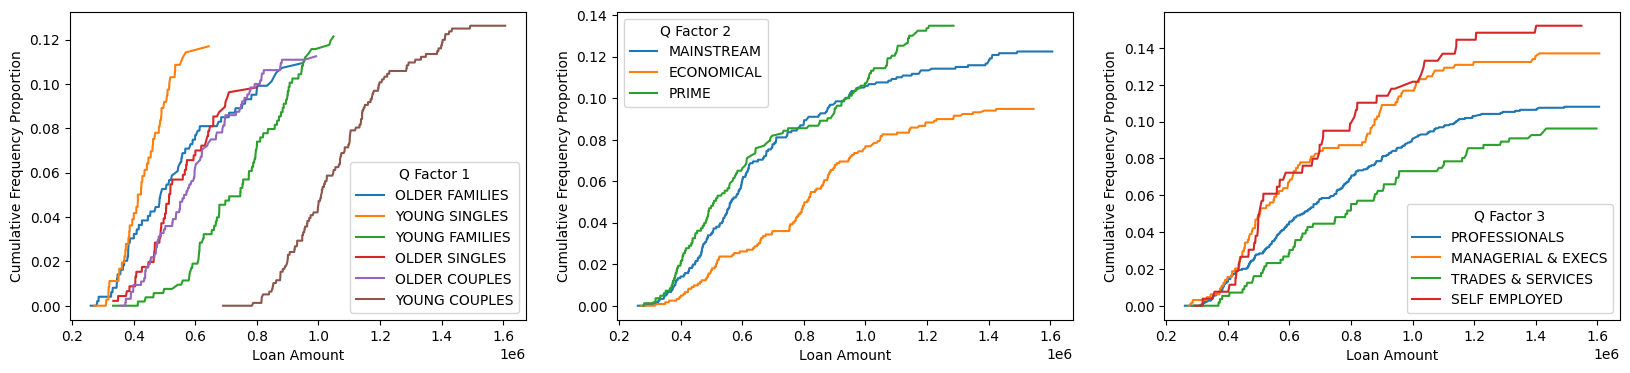

In [43]:
#plotting cumulative frequency of clawbacks as a proportion to loan amounts, differentiating by Q factors (STANDARDISING FOR UNEQUAL LOAN APPLICATION COUNTS) 
fig, ax = plt.subplots(1,3, figsize = (20,4))
for i in range(3):
    count_df = df.groupby(f'Q Factor {i+1}')['Customer ID'].count()
    cumfreq_df = df[['Loan Amount', 'Clawbacked', f'Q Factor {i+1}']].sort_values('Loan Amount')
    cumfreq_df['Cumulative Frequency Proportion'] = cumfreq_df.groupby(f'Q Factor {i+1}')['Clawbacked'].cumsum()
    cumfreq_df['Cumulative Frequency Proportion'] = cumfreq_df['Cumulative Frequency Proportion'].astype('float64')
    for factor in count_df.index:
        cumfreq_df.loc[cumfreq_df[f'Q Factor {i+1}'] == factor , 'Cumulative Frequency Proportion'] /= count_df[factor]
    fig = sns.lineplot(cumfreq_df, x = 'Loan Amount', y = 'Cumulative Frequency Proportion', hue=f'Q Factor {i+1}', ax = ax[i])

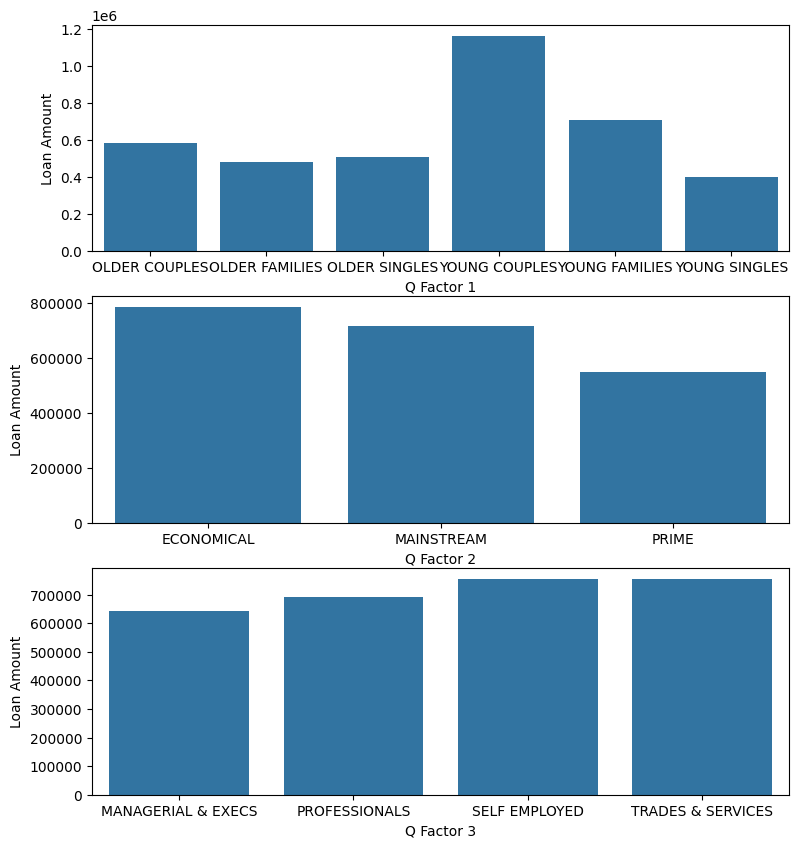

In [44]:
# Finding average loan amounts by Q factors
fig, ax = fa(3,1,(9,10))
for i in range(3):
    df.groupby(f'Q Factor {i+1}')['Loan Amount'].mean()
    sns.barplot(df.groupby(f'Q Factor {i+1}')['Loan Amount'].mean(),ax=ax[i])

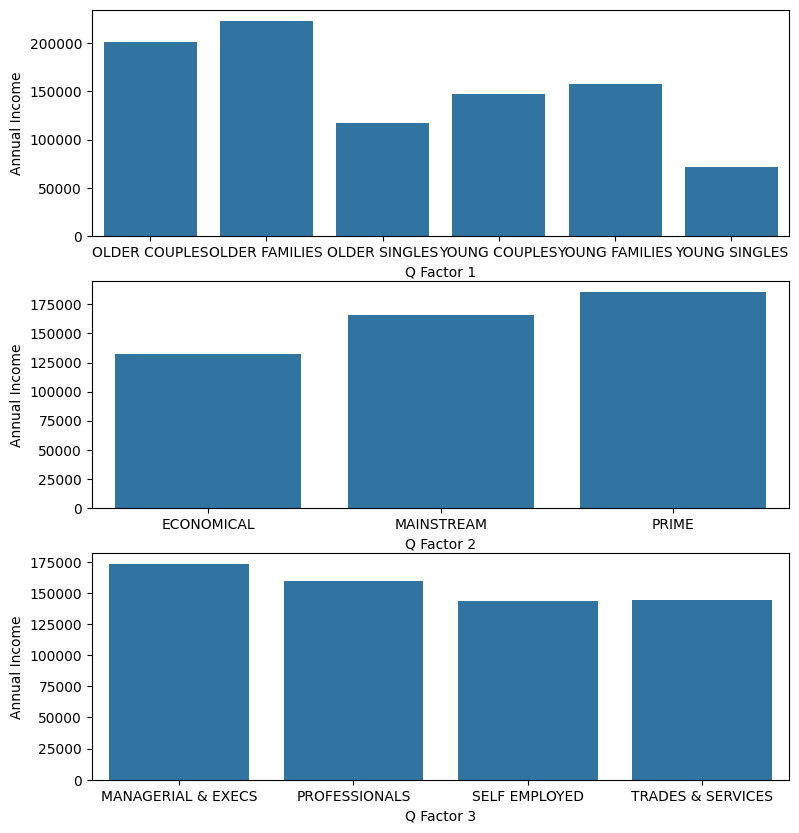

In [45]:
# Finding average annual income according to Q factors
fig, ax = fa(3,1,(9,10))
for i in range(3):
    df.groupby(f'Q Factor {i+1}')['Annual Income'].mean()
    sns.barplot(df.groupby(f'Q Factor {i+1}')['Annual Income'].mean(),ax=ax[i])

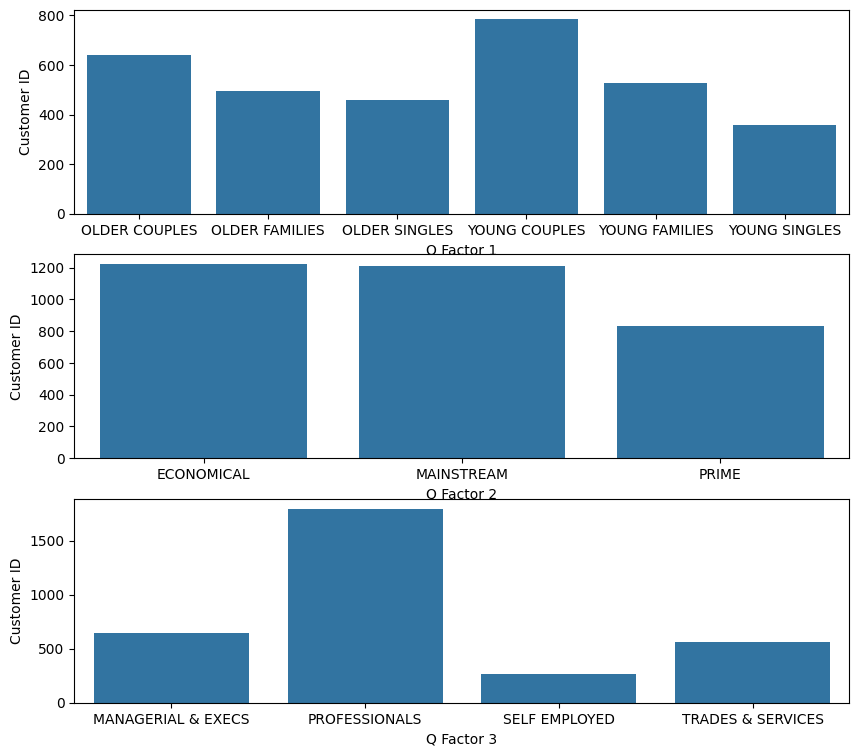

In [46]:
# Finding no. of applications put in by each Q factor
fig, ax = fa(3,1,(10,9))
for i in range(3):
    sns.barplot(df.groupby(f'Q Factor {i+1}')['Customer ID'].count(), ax = ax[i])

<Axes: xlabel='Annual Income', ylabel='Cumulative Frequency Proportion'>

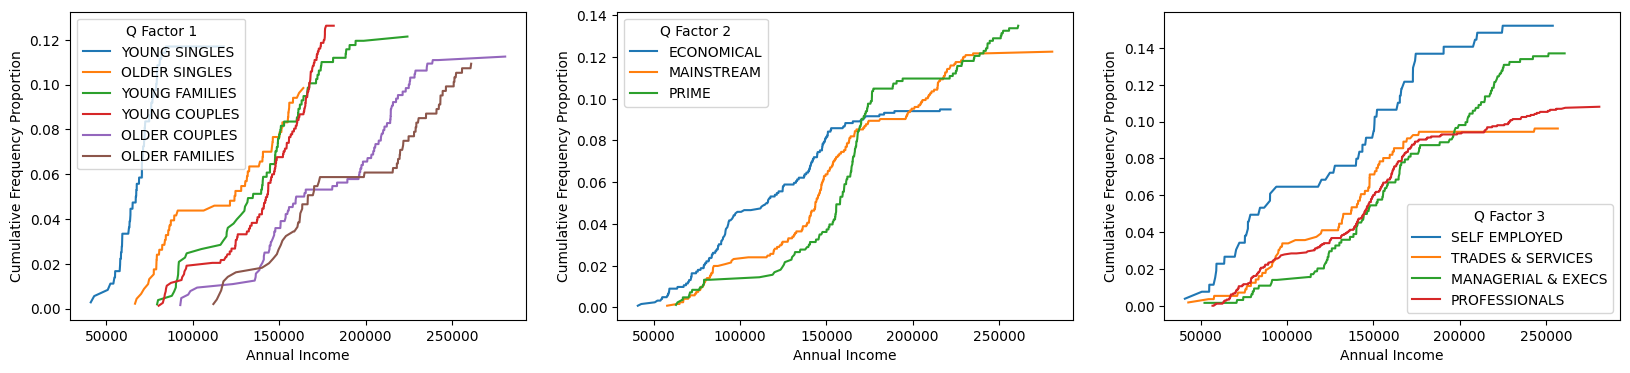

In [47]:
#looking at the effect of annual income to clawback frequency across different Q factors, standardising for loan count
fig, ax = plt.subplots(1,3, figsize = (20,4))
for i in range(3):
    cumfreq_df = df[['Annual Income', 'Clawbacked', f'Q Factor {i+1}']].sort_values('Annual Income')
    cumfreq_df['Cumulative Frequency'] = cumfreq_df.groupby(f'Q Factor {i+1}')['Clawbacked'].cumsum()
    count_df = df.groupby(f'Q Factor {i+1}')['Customer ID'].count()
    cumfreq_df['Cumulative Frequency Proportion'] = cumfreq_df.groupby(f'Q Factor {i+1}')['Clawbacked'].cumsum()
    cumfreq_df['Cumulative Frequency Proportion'] = cumfreq_df['Cumulative Frequency Proportion'].astype('float64')
    for factor in count_df.index:
        cumfreq_df.loc[cumfreq_df[f'Q Factor {i+1}'] == factor , 'Cumulative Frequency Proportion'] /= count_df[factor]
    fig = sns.lineplot(cumfreq_df, x = 'Annual Income', y = 'Cumulative Frequency Proportion', hue=f'Q Factor {i+1}', ax = ax[i])
fig

<Axes: xlabel='Interest Rate (p.a.)', ylabel='Cumulative Frequency Proportion'>

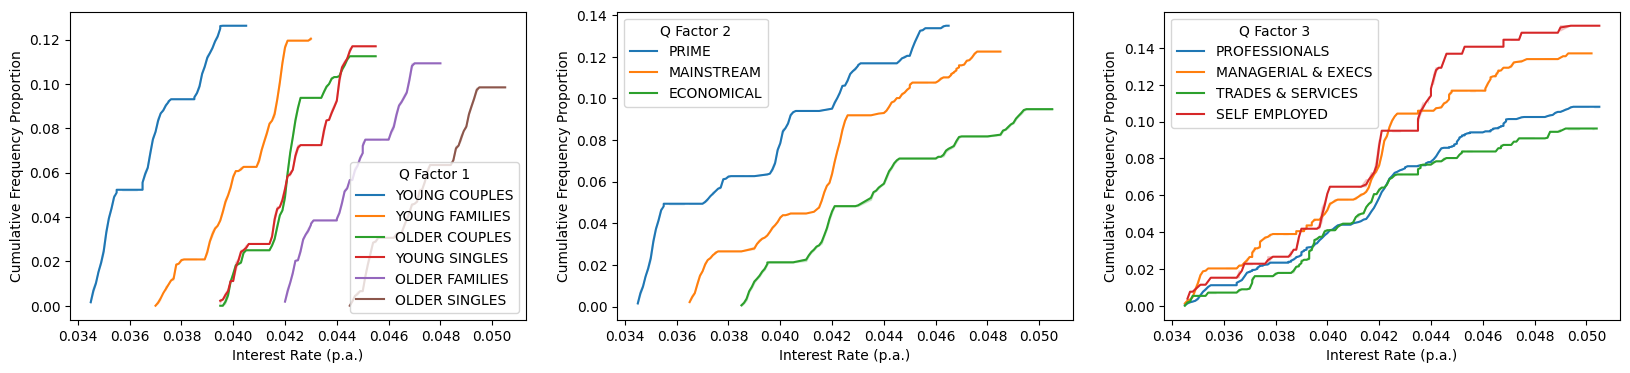

In [48]:
#looking at the effect of interest rate to clawback frequency across different Q factors
fig, ax = plt.subplots(1,3, figsize = (20,4))
for i in range(3):
    cumfreq_df = df[['Interest Rate (p.a.)', 'Clawbacked', f'Q Factor {i+1}']].sort_values('Interest Rate (p.a.)')
    cumfreq_df['Cumulative Frequency Proportion'] = cumfreq_df.groupby(f'Q Factor {i+1}')['Clawbacked'].cumsum().astype('float64')
    count_df = df.groupby(f'Q Factor {i+1}')['Customer ID'].count()
    for factor in count_df.index:
        cumfreq_df.loc[cumfreq_df[f'Q Factor {i+1}'] == factor , 'Cumulative Frequency Proportion'] /= count_df[factor]
    fig = sns.lineplot(cumfreq_df, x = 'Interest Rate (p.a.)', y = 'Cumulative Frequency Proportion', hue=f'Q Factor {i+1}', ax = ax[i])
fig

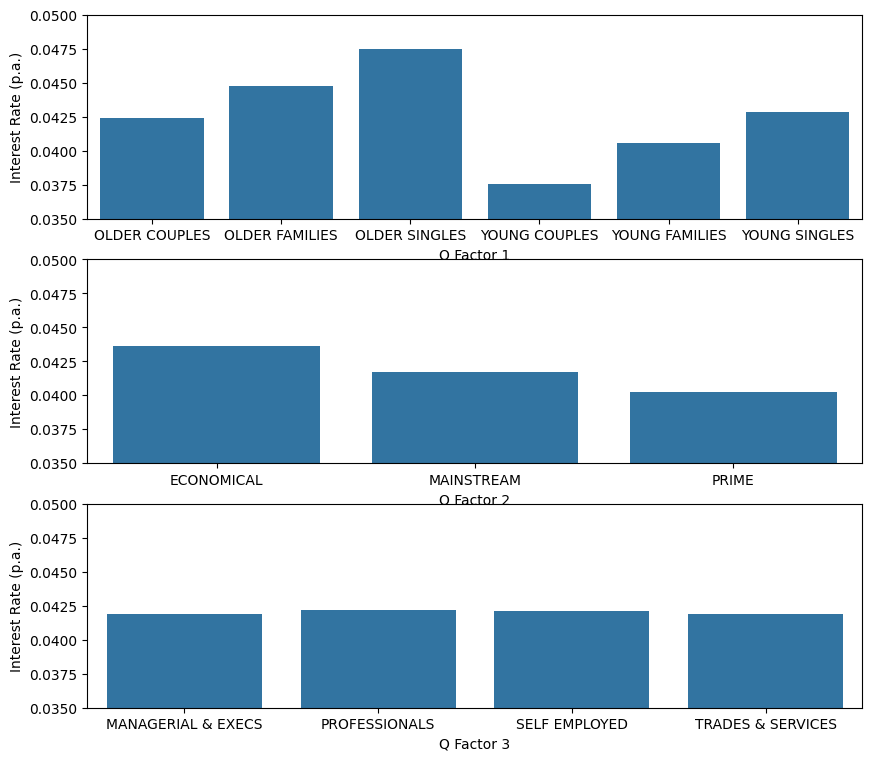

In [49]:
# Finding average interest rate per Q factors
fig, ax = fa(3,1,(10,9))
for i in range(3):
    ax[i].set_ylim(0.035,0.05)
    sns.barplot(df.groupby(f'Q Factor {i+1}')['Interest Rate (p.a.)'].mean(), ax = ax[i])

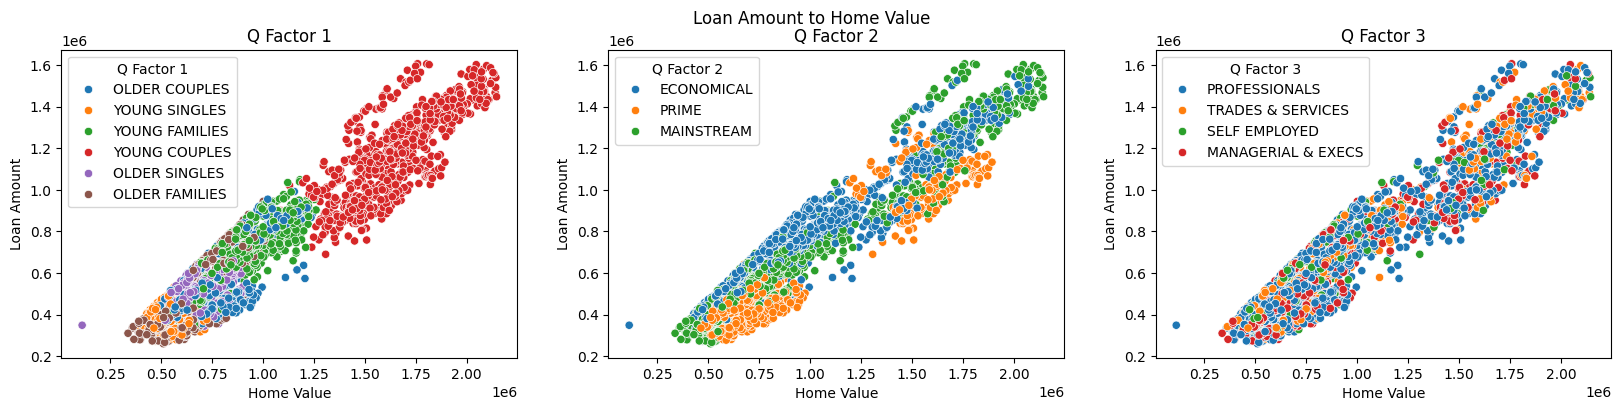

In [50]:
fig, ax = fa(1,3,(20,4))
fig.suptitle('Loan Amount to Home Value')
for i in range(3):
    ax[i].set_title(f'Q Factor {i+1}')
    sns.scatterplot(df, x = 'Home Value', y = 'Loan Amount', hue=f'Q Factor {i+1}', ax = ax[i])

## ANALYSIS:
Q FACTOR 1:
- Young couples have higher clawback counts but take much larger loan amounts despite being the group with 4th highest average annual income, they are also the group with most applications. possibly why they fail on repayments more
    - Generally, Young couples are buying more expensive homes and hus taking larger loans  
    - Young couples had lower average interest rates than their counterparts 
- After standardising for application count, the plot suggests young singles have higher clawback counts for smaller loan amounts, possibly due to only having a single income 
(as compared to an income of two, or a more matured and bigger income an older single may have)
    - Young singles are the riskiest.
- Young families seem to have low clawback counts compared to their counterparts (excluding young couples) for the same range of loan amounts

Q Factor 2:
- Economical have the lowest clawback counts compared to its counterparts for all ranges of loan amounts
- Economical had the highest average loan amount and lowest annual income, but still had lower counts of clawbacks than their counterparts, suggesting they are a better group to target
    - Lower proportional frequency for any given interest rate as well
- Prime had a marginally higher clawback cumulative frequency in proportion to the number of loans they apply for, even though they had the lowest loan counts, highest annual income and lowest loan amount average. This suggests they are the the riskiest of the three
    - Prime customers were the riskiest for any given interest rate, as they had the highest clawback counts


Q Factor 3:
- Although Professionals have higher clawback counts, this may be influenced by the large no. of loans they apply for in comparison with their counterparts (more than 3x the amount of loans self employed applied for).
- After standardising for loan counts, customers in the professional and trades and services had proportionally fewer clawbacks whereas self employed and managerial & execs had the highest counts 


<Axes: xlabel='Loan Amount', ylabel='Density'>

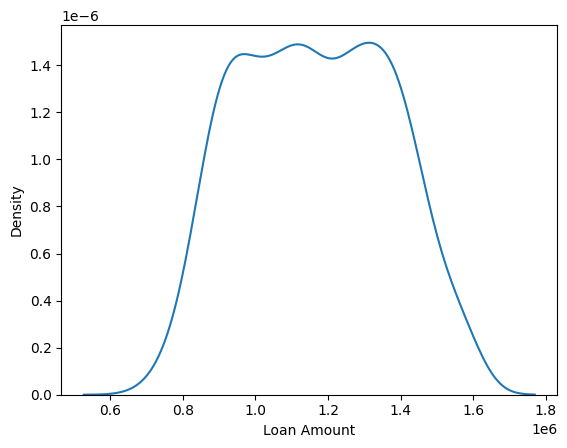

In [51]:
young_couples_loan_size = df[df['Q Factor 1'] == 'YOUNG COUPLES']['Loan Amount']
sns.kdeplot(young_couples_loan_size)

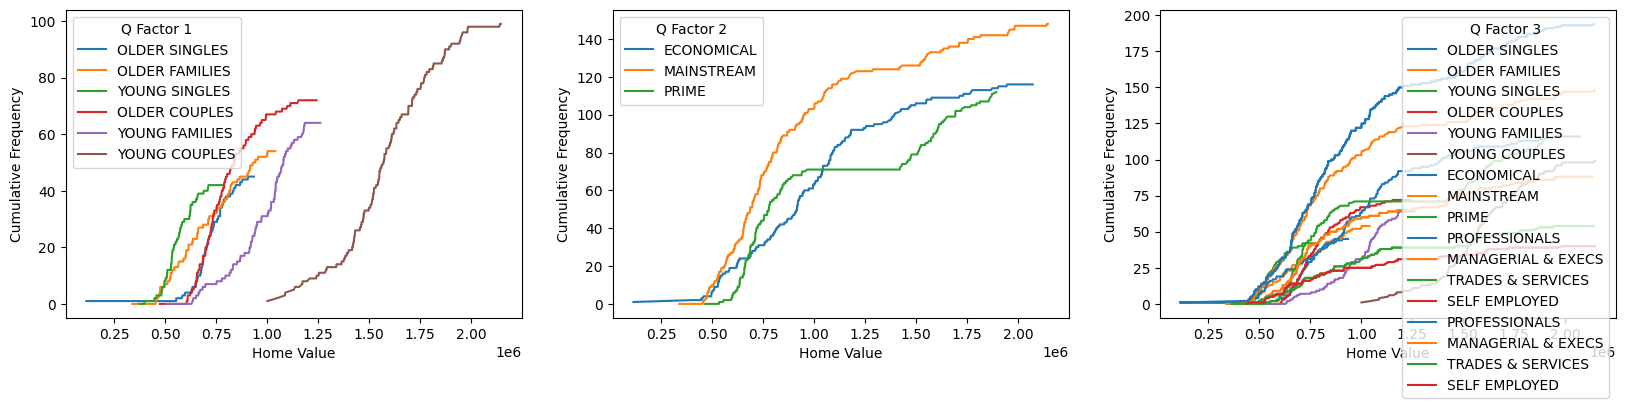

In [52]:
fig, ax = plt.subplots(1,3, figsize = (20,4))
for i in range(3):
    cumfreq_graph('Home Value', f'Q Factor {i+1}', ax=ax[i])
    

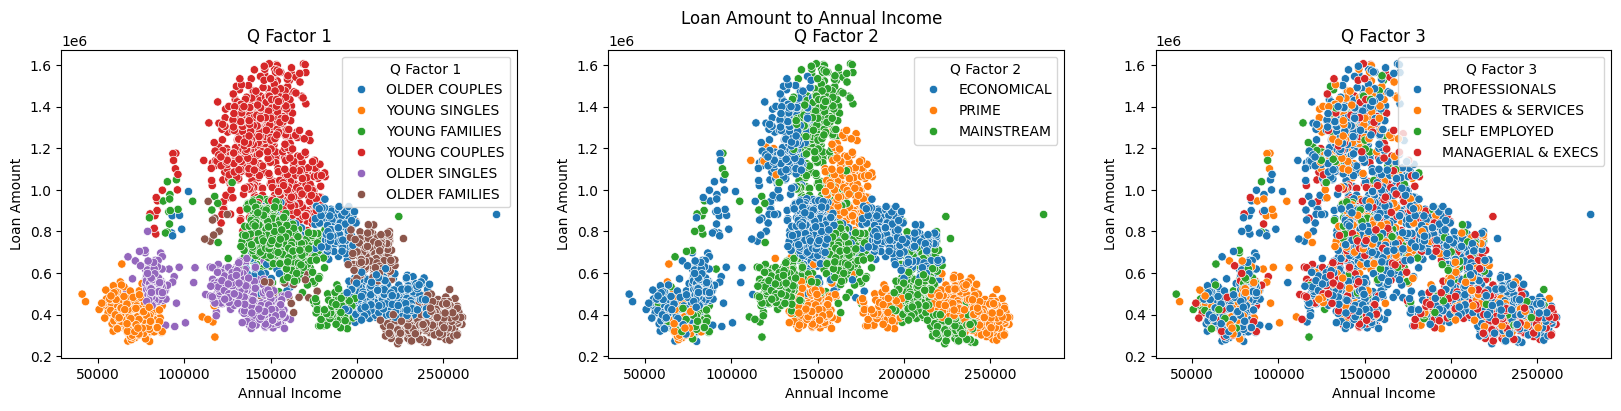

In [53]:
# Loan Amount to Annual Income for different Q factors
fig, ax = fa(1,3,(20,4))
fig.suptitle('Loan Amount to Annual Income')
for i in range(3):
    ax[i].set_title(f'Q Factor {i+1}')
    sns.scatterplot(df, x = 'Annual Income', y = 'Loan Amount', hue=f'Q Factor {i+1}', ax = ax[i])

### investigating campaign and loan amounts effect on clawback frequency (while standardising for loan counts)

In [54]:
df['Campaign Name'].unique()

array(['Own marketing', 'TV campaign - instant approvals',
       'RiskyLending special'], dtype=object)

Text(0.5, 1.0, '*While standardising for Loan counts*')

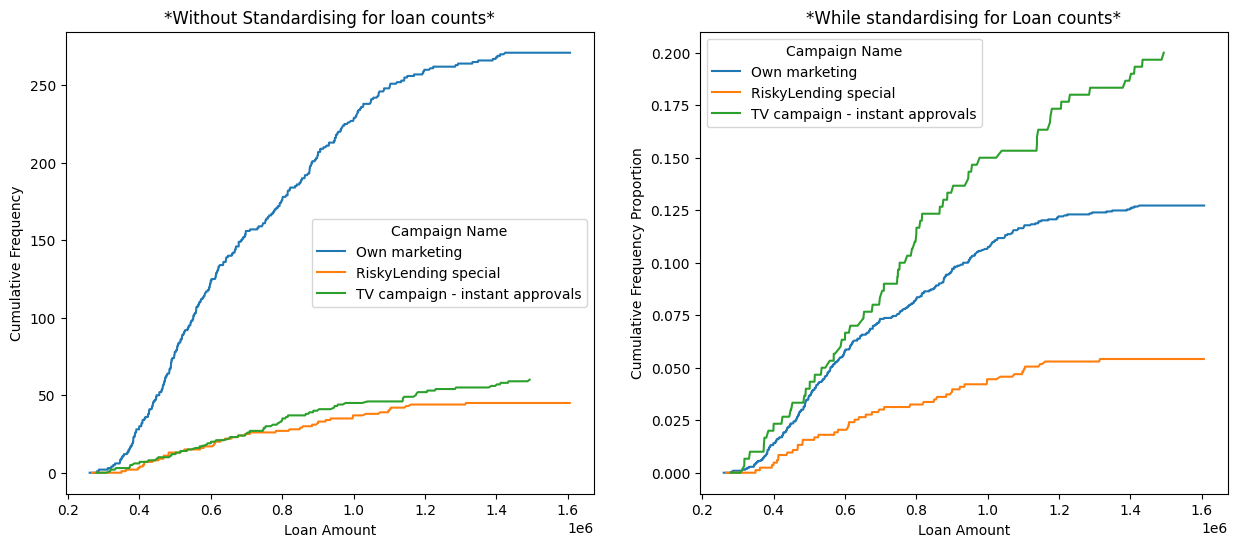

In [55]:
fig, ax = fa(1,2, (15,6))
cumfreq_df = df[['Loan Amount', 'Clawbacked', 'Campaign Name']].sort_values('Loan Amount')
cumfreq_df['Cumulative Frequency'] = cumfreq_df.groupby('Campaign Name')['Clawbacked'].cumsum()
sns.lineplot(cumfreq_df, x = 'Loan Amount', y = 'Cumulative Frequency', hue='Campaign Name', ax = ax[0])
ax[0].set_title('*Without Standardising for loan counts*')

counts_df = df.groupby('Campaign Name')['Customer ID'].count()
cumfreq_df['Cumulative Frequency Proportion'] = cumfreq_df.groupby('Campaign Name')['Clawbacked'].cumsum().astype('float64')
for factor in counts_df.index:
    cumfreq_df.loc[cumfreq_df['Campaign Name'] == factor, 'Cumulative Frequency Proportion'] /= counts_df[factor]
sns.lineplot(cumfreq_df, x = 'Loan Amount', y = 'Cumulative Frequency Proportion', hue='Campaign Name', ax = ax[1])
ax[1].set_title('*While standardising for Loan counts*')

In [56]:
# No. of customers from each campaign
counts_df

Campaign Name
Own marketing                      2130
RiskyLending special                831
TV campaign - instant approvals     300
Name: Customer ID, dtype: int64

In [57]:
df.groupby('Campaign Name')['Clawbacked'].sum()

Campaign Name
Own marketing                      271
RiskyLending special                45
TV campaign - instant approvals     60
Name: Clawbacked, dtype: int64

<Axes: xlabel='Annual Income', ylabel='Loan Amount'>

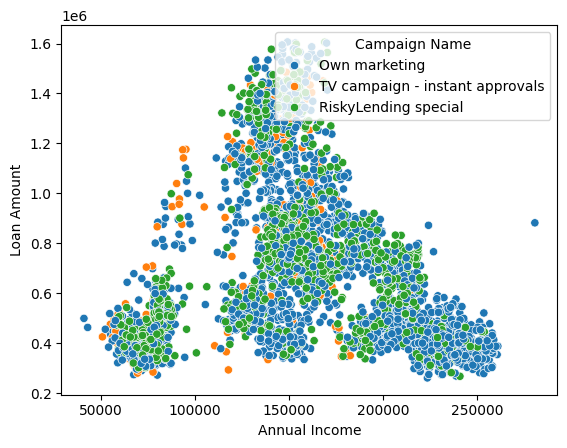

In [58]:
sns.scatterplot(df, x = 'Annual Income', y = 'Loan Amount', hue='Campaign Name')

# Analysis
- Although own marketing has highest clawback counts, might be due to the large no. of application counts
- In proportion to no. of application counts, we see that the TV - Special is the riskiest as they have the highest no. of clawbacks proportionally

## Next steps:
- Look at impact of home value for differing Q factors
- Look at Clawback delay for differing Q factors
- Look at relationship between clawback delay and interest rate
- Clawback delay and Q factor
- Campaign and Clawback frequency
- Campaign and clawback delay
- Loan amount to Annual income, differing between campaigns (AND Q FACTORS)
- difference between loan amount and home value, differeng between different factors

In [59]:
df['Loan In Excess to Home Value'] = df['Loan Amount']- df['Home Value']

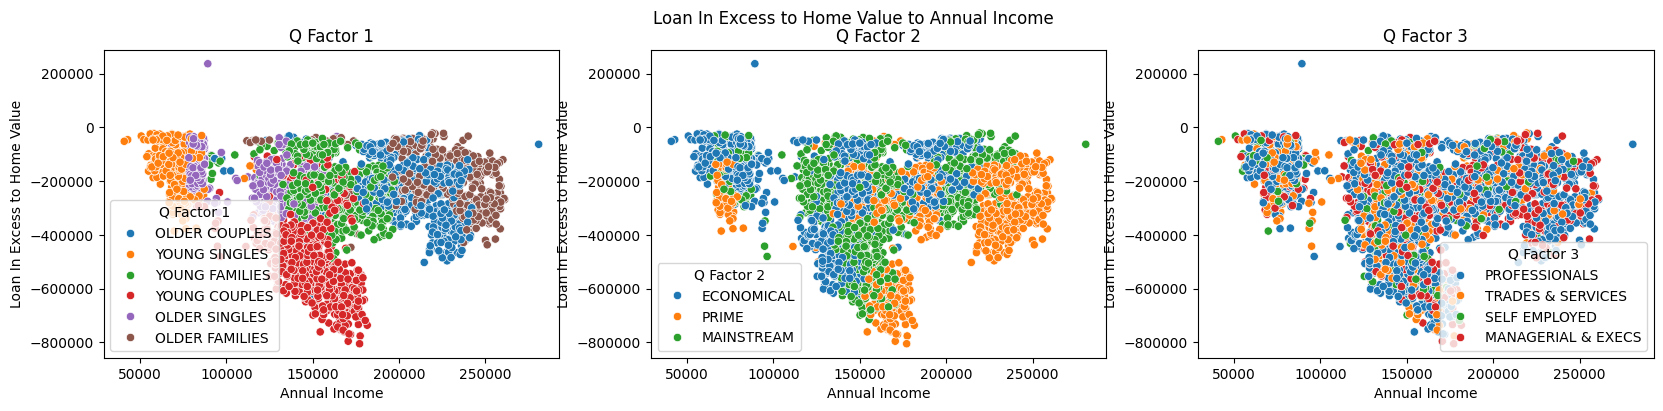

In [60]:
# Loan Amount to Annual Income for different Q factors
fig, ax = fa(1,3,(20,4))
fig.suptitle('Loan In Excess to Home Value to Annual Income')
for i in range(3):
    ax[i].set_title(f'Q Factor {i+1}')
    sns.scatterplot(df, x = 'Annual Income', y = 'Loan In Excess to Home Value', hue=f'Q Factor {i+1}', ax = ax[i])

<Axes: xlabel='Annual Income', ylabel='Loan In Excess to Home Value'>

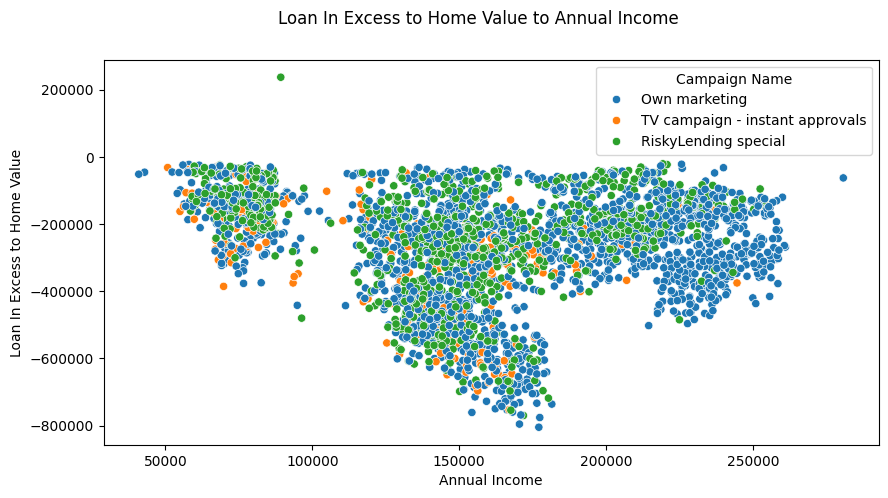

In [61]:
fig, ax = fa(1,1,(10,5))
fig.suptitle('Loan In Excess to Home Value to Annual Income')
sns.scatterplot(df, x = 'Annual Income', y = 'Loan In Excess to Home Value', hue='Campaign Name', ax = ax)

<Axes: xlabel='Annual Income', ylabel='Loan Amount'>

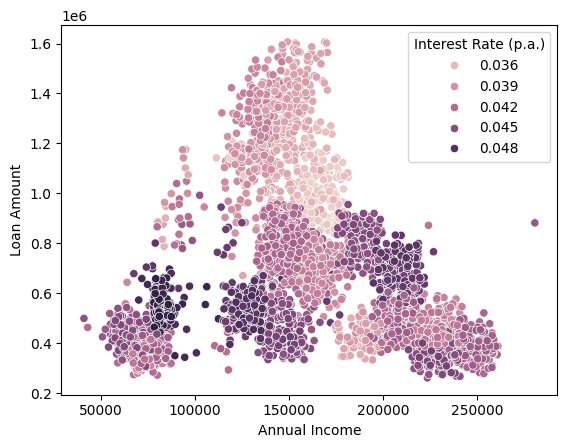

In [62]:
sns.scatterplot(df, x = 'Annual Income', y = 'Loan Amount', hue='Interest Rate (p.a.)')

<Axes: xlabel='Annual Income', ylabel='Loan In Excess to Home Value'>

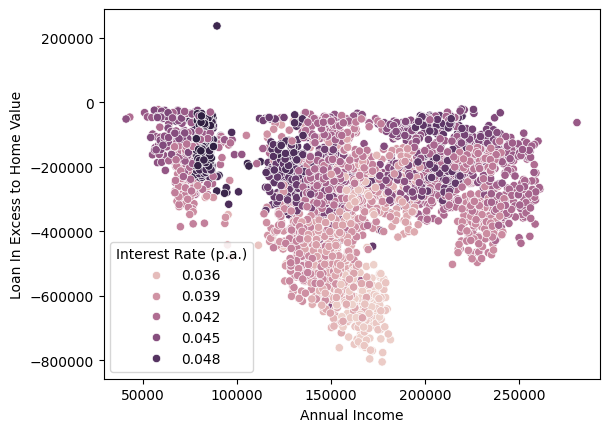

In [63]:
sns.scatterplot(df, x = 'Annual Income', y = 'Loan In Excess to Home Value', hue='Interest Rate (p.a.)')

## Looking at the delay until clawback

In [64]:
df.columns

Index(['Customer ID', 'Campaign ID', 'Contact Date', 'DOB', 'Q Factor 1',
       'Q Factor 2', 'Q Factor 3', 'Application ID', 'Application Date',
       'Loan Amount', 'Home Value', 'Annual Income', 'Interest Rate (p.a.)',
       'Term (months)', 'Account ID', 'Account Open Date_x', 'Campaign Name',
       'Campaign Start', 'Campaign End', 'Campaign Offer',
       'Administration Expense', 'Service Expense', 'Clawbacked',
       'Account Open Date_y', 'Account Close Date', 'Close Reason',
       'open date + 12 mths', 'Loan In Excess to Home Value'],
      dtype='object')

In [65]:
df['Clawback Delay'] = df['Account Close Date'] - df['Account Open Date_y']
#defining clawback delay
clawback_delay = df[df['Clawback Delay'] != 0]

In [66]:
df[df['Clawback Delay'] != 0].columns

Index(['Customer ID', 'Campaign ID', 'Contact Date', 'DOB', 'Q Factor 1',
       'Q Factor 2', 'Q Factor 3', 'Application ID', 'Application Date',
       'Loan Amount', 'Home Value', 'Annual Income', 'Interest Rate (p.a.)',
       'Term (months)', 'Account ID', 'Account Open Date_x', 'Campaign Name',
       'Campaign Start', 'Campaign End', 'Campaign Offer',
       'Administration Expense', 'Service Expense', 'Clawbacked',
       'Account Open Date_y', 'Account Close Date', 'Close Reason',
       'open date + 12 mths', 'Loan In Excess to Home Value',
       'Clawback Delay'],
      dtype='object')

In [67]:
clawback_delay['Clawback Delay'] = clawback_delay['Clawback Delay'].apply(lambda x: x.days)

/var/folders/hv/zv65r5j52zgd1nc0cykq3pv00000gn/T/ipykernel_10221/3671209917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clawback_delay['Clawback Delay'] = clawback_delay['Clawback Delay'].apply(lambda x: x.days)


<Axes: xlabel='Interest Rate (p.a.)', ylabel='Clawback Delay'>

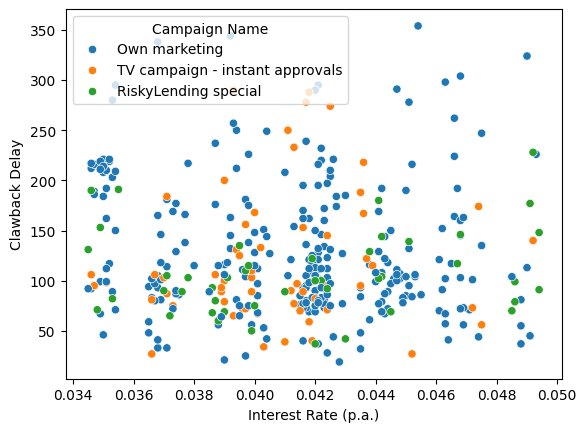

In [68]:
# with respect to interest rate
sns.scatterplot(data=clawback_delay, x = 'Interest Rate (p.a.)',y ='Clawback Delay', hue='Campaign Name')

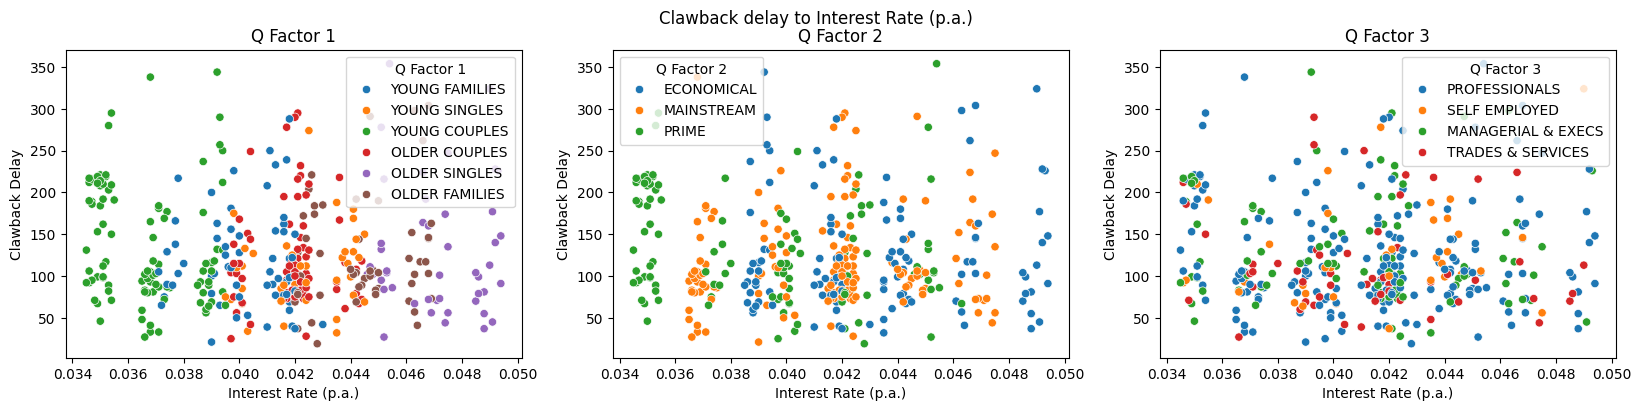

In [69]:
# Loan Amount to Annual Income for different Q factors
fig, ax = fa(1,3,(20,4))
var = 'Interest Rate (p.a.)'
fig.suptitle(f'Clawback delay to {var}')
for i in range(3):
    ax[i].set_title(f'Q Factor {i+1}')
    sns.scatterplot(clawback_delay, x = var, y = 'Clawback Delay', hue=f'Q Factor {i+1}', ax = ax[i])

TypeError: Invalid object type at position 2

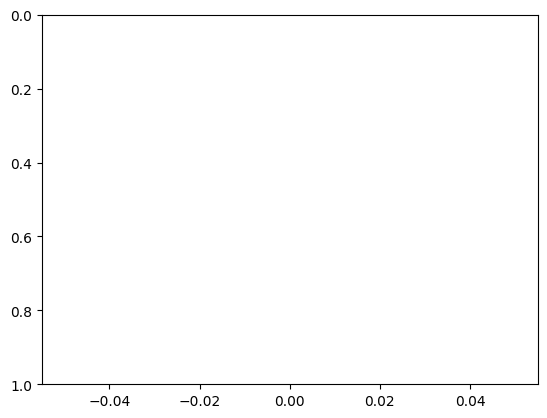

In [70]:
sns.scatterplot(df['Clawback Delay'])

frequency of clawbacks wrt loan in excess of home value
(NOTE NOW ITS HOME VALUE - LOAN, BEFORE IT WAS THE OTHER WAY AROUND)
- initial prediction, the higher the Home value is in excess to the loan, the more clawbacks

(THEN CONTINUE ON TO DOING CUMULATIVE FREQUENCY)

In [ ]:
df['Home Value in excess of Loan Amount'] = -df['Loan In Excess to Home Value']

In [ ]:
df.columns

Index(['Customer ID', 'Campaign ID', 'Contact Date', 'DOB', 'Q Factor 1',
       'Q Factor 2', 'Q Factor 3', 'Application ID', 'Application Date',
       'Loan Amount', 'Home Value', 'Annual Income', 'Interest Rate (p.a.)',
       'Term (months)', 'Account ID', 'Account Open Date_x', 'Campaign Name',
       'Campaign Start', 'Campaign End', 'Campaign Offer',
       'Administration Expense', 'Service Expense', 'Clawbacked',
       'Account Open Date_y', 'Account Close Date', 'Close Reason',
       'open date + 12 mths', 'Loan In Excess to Home Value', 'Clawback Delay',
       'Home Value in excess of Loan Amount'],
      dtype='object')

In [ ]:
df[['Home Value in excess of Loan Amount', 'Clawbacked']]

Home Value in excess of Loan Amount  Clawbacked
0                               256088.00           0
1                               279760.00           0
2                               113822.76           1
3                               110940.88           1
4                               448897.12           0
...                                   ...         ...
3256                             27202.83           0
3257                            561364.00           0
3258                            450708.00           0
3259                            126096.80           0
3260                            205437.65           0

[3261 rows x 2 columns]

<Axes: xlabel='Home Value in excess of Loan Amount', ylabel='Cumulative Frequency Proportion'>

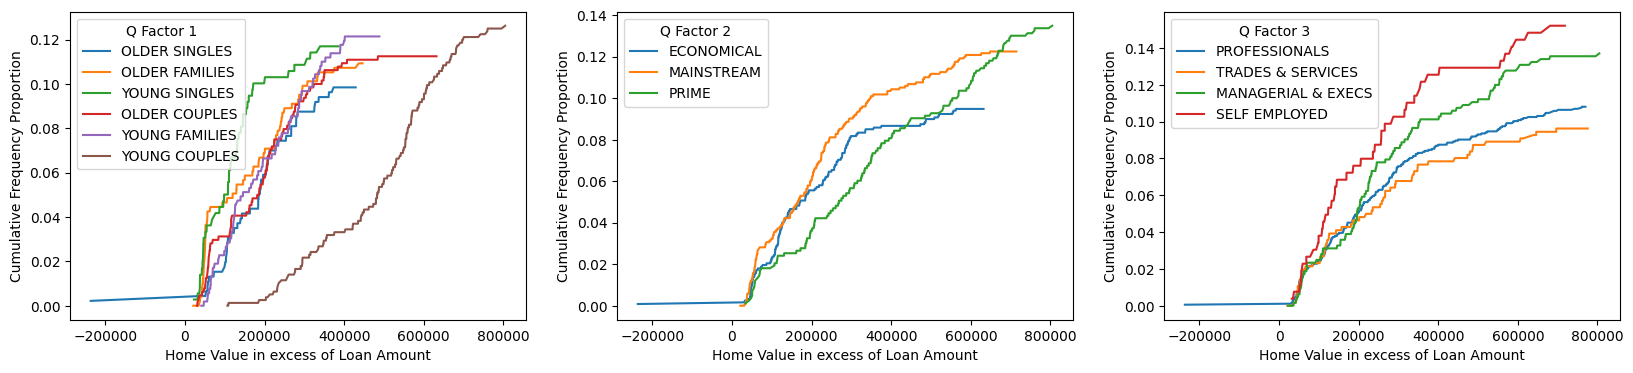

In [ ]:
#looking at the effect of annual income to clawback frequency across different Q factors, standardising for loan count
fig, ax = plt.subplots(1,3, figsize = (20,4))
for i in range(3):
    cumfreq_df = df[['Home Value in excess of Loan Amount', 'Clawbacked', f'Q Factor {i+1}']].sort_values('Home Value in excess of Loan Amount')
    cumfreq_df['Cumulative Frequency'] = cumfreq_df.groupby(f'Q Factor {i+1}')['Clawbacked'].cumsum()
    count_df = df.groupby(f'Q Factor {i+1}')['Customer ID'].count()
    cumfreq_df['Cumulative Frequency Proportion'] = cumfreq_df.groupby(f'Q Factor {i+1}')['Clawbacked'].cumsum()
    cumfreq_df['Cumulative Frequency Proportion'] = cumfreq_df['Cumulative Frequency Proportion'].astype('float64')
    for factor in count_df.index:
        cumfreq_df.loc[cumfreq_df[f'Q Factor {i+1}'] == factor , 'Cumulative Frequency Proportion'] /= count_df[factor]
    fig = sns.lineplot(cumfreq_df, x = 'Home Value in excess of Loan Amount', y = 'Cumulative Frequency Proportion', hue=f'Q Factor {i+1}', ax = ax[i])
fig

<Axes: title={'center': 'CF(clawbacks) to Home value in excess of Loan amount'}, xlabel='Home Value in excess of Loan Amount', ylabel='Cumulative Frequency Proportion'>

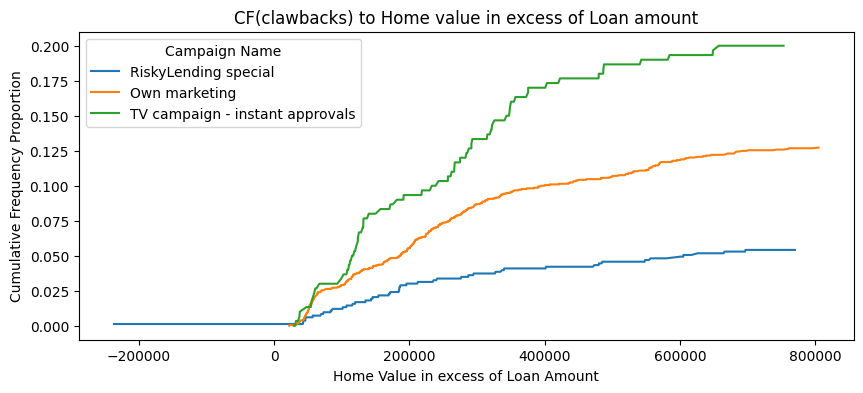

In [ ]:
f,a = fa(1,1,(10,4))
cumfreq_df = df[['Home Value in excess of Loan Amount', 'Clawbacked', 'Campaign Name']].sort_values('Home Value in excess of Loan Amount')
cumfreq_df['Cumulative Frequency'] = cumfreq_df.groupby('Campaign Name')['Clawbacked'].cumsum()
count_df = df.groupby('Campaign Name')['Customer ID'].count()
cumfreq_df['Cumulative Frequency Proportion'] = cumfreq_df['Cumulative Frequency'].astype('float64')
for c in count_df.index:
    cumfreq_df.loc[cumfreq_df['Campaign Name']==c, 'Cumulative Frequency Proportion'] /= count_df[c]
a.set_title('CF(clawbacks) to Home value in excess of Loan amount')
sns.lineplot(cumfreq_df, x = 'Home Value in excess of Loan Amount', y = 'Cumulative Frequency Proportion', hue='Campaign Name', ax = a)


# Next steps
- How relationship between interest rate and clawback has changed over time
- Relationship between interest rate of loan and cash rate
    - How they interact with clawback counts AND clawback delay

### Clawback delay wrt interest rate over time

REMOVING DATA ENTRY WITH ACCOUNT CLOSE DATE AFTER JULY (probably a data error)

In [103]:
df.shape

(3261, 29)

In [105]:
df.drop(index=2245,inplace = True)

In [114]:
plotdata = df
plotdata['Weeks'] = (plotdata['Account Open Date_x']-min(plotdata['Account Open Date_x'])).apply(lambda x: x.days)
plotdata.columns

Index(['Customer ID', 'Campaign ID', 'Contact Date', 'DOB', 'Q Factor 1',
       'Q Factor 2', 'Q Factor 3', 'Application ID', 'Application Date',
       'Loan Amount', 'Home Value', 'Annual Income', 'Interest Rate (p.a.)',
       'Term (months)', 'Account ID', 'Account Open Date_x', 'Campaign Name',
       'Campaign Start', 'Campaign End', 'Campaign Offer',
       'Administration Expense', 'Service Expense', 'Clawbacked',
       'Account Open Date_y', 'Account Close Date', 'Close Reason',
       'open date + 12 mths', 'Loan In Excess to Home Value', 'Clawback Delay',
       'Weeks'],
      dtype='object')

In [125]:
plotdata['Account Close Date']

<bound method Series.notnull of 0                         0
1                         0
2       2020-08-30 00:00:00
3       2020-09-23 00:00:00
4                         0
               ...         
3256                      0
3257                      0
3258                      0
3259                      0
3260                      0
Name: Account Close Date, Length: 3260, dtype: object>

In [130]:
plotdata['Clawback Delay'] = plotdata[plotdata['Clawbacked'] == 1]['Clawback Delay'].apply(lambda x: x.days)


<Axes: xlabel='Interest Rate (p.a.)', ylabel='Clawback Delay'>

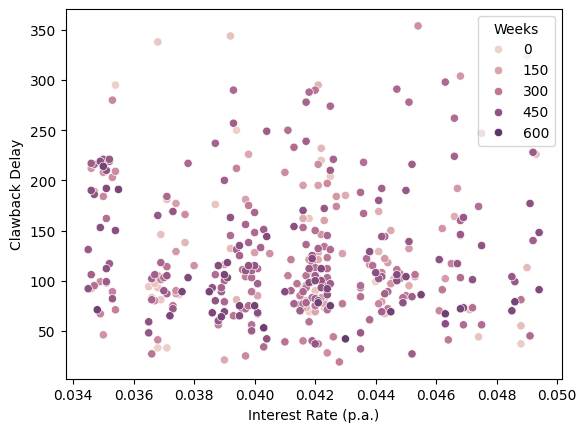

In [135]:
sns.scatterplot(data = plotdata, x = 'Interest Rate (p.a.)',y= 'Clawback Delay', hue='Weeks')

<Axes: xlabel='Account Open Date_x', ylabel='Interest Rate (p.a.)'>

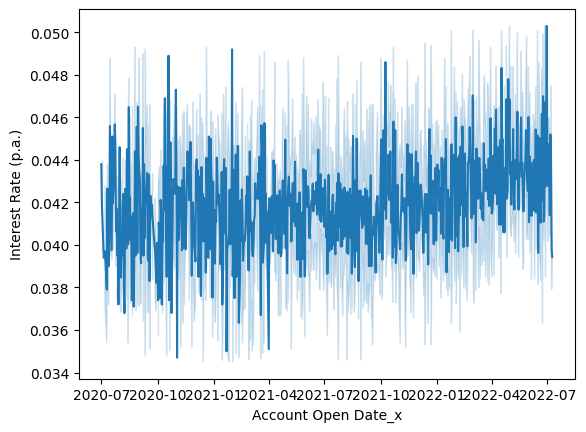

In [136]:
# How interest rate has changed over time
sns.lineplot(data = df, x = 'Account Open Date_x', y = 'Interest Rate (p.a.)')

In [142]:
plotdata.columns

Index(['Customer ID', 'Campaign ID', 'Contact Date', 'DOB', 'Q Factor 1',
       'Q Factor 2', 'Q Factor 3', 'Application ID', 'Application Date',
       'Loan Amount', 'Home Value', 'Annual Income', 'Interest Rate (p.a.)',
       'Term (months)', 'Account ID', 'Account Open Date_x', 'Campaign Name',
       'Campaign Start', 'Campaign End', 'Campaign Offer',
       'Administration Expense', 'Service Expense', 'Clawbacked',
       'Account Open Date_y', 'Account Close Date', 'Close Reason',
       'open date + 12 mths', 'Loan In Excess to Home Value', 'Clawback Delay',
       'Weeks'],
      dtype='object')

<Axes: xlabel='Weeks', ylabel='Interest Rate (p.a.)'>

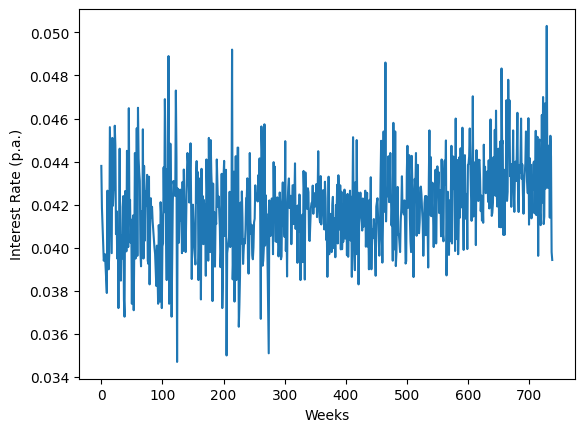

In [144]:
#grouping by week first, then plotting average weekly interest rate over time
plotdata['Months'] = (plotdata['Account Open Date_x']-min(plotdata['Account Open Date_x'])).apply(lambda x: x.days)
sns.lineplot(plotdata.groupby('Weeks')['Interest Rate (p.a.)'].mean())

# After meeting

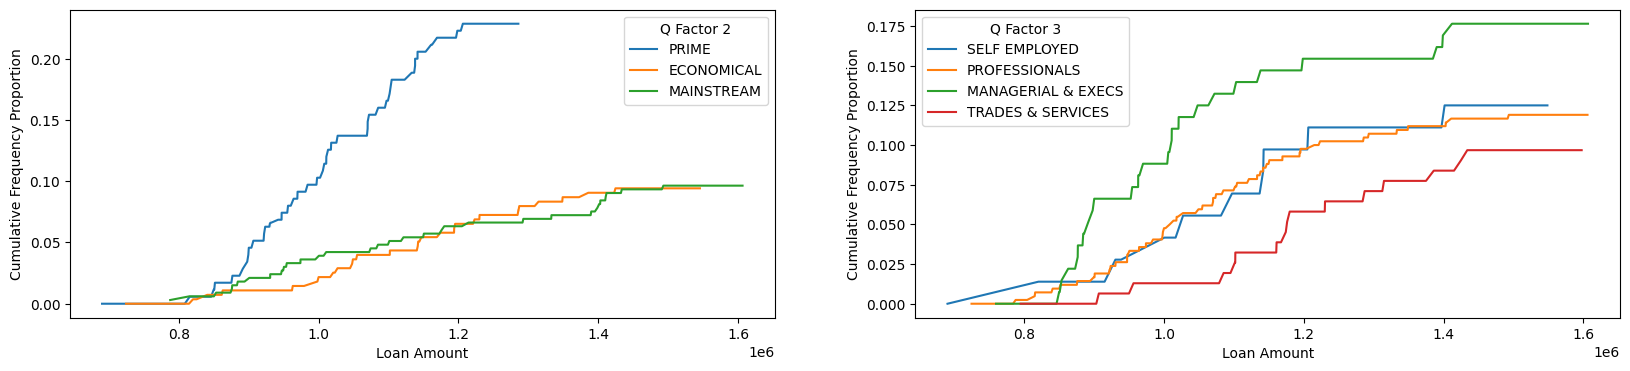

In [147]:
# Looking at CF of loan to LOAN amount for young couples
young_couples = df[df['Q Factor 1']=='YOUNG COUPLES']
fig, ax = plt.subplots(1,2, figsize = (20,4))
for i in range(1,3):
    cumfreq_df = young_couples[['Loan Amount', 'Clawbacked', f'Q Factor {i+1}']].sort_values('Loan Amount')
    cumfreq_df['Cumulative Frequency'] = cumfreq_df.groupby(f'Q Factor {i+1}')['Clawbacked'].cumsum()
    count_df = young_couples.groupby(f'Q Factor {i+1}')['Customer ID'].count()
    cumfreq_df['Cumulative Frequency Proportion'] = cumfreq_df['Cumulative Frequency'].astype('float64')
    for factor in count_df.index:
        cumfreq_df.loc[cumfreq_df[f'Q Factor {i+1}'] == factor , 'Cumulative Frequency Proportion'] /= count_df[factor]
    fig = sns.lineplot(cumfreq_df, x = 'Loan Amount', y = 'Cumulative Frequency Proportion', hue=f'Q Factor {i+1}', ax = ax[i-1])


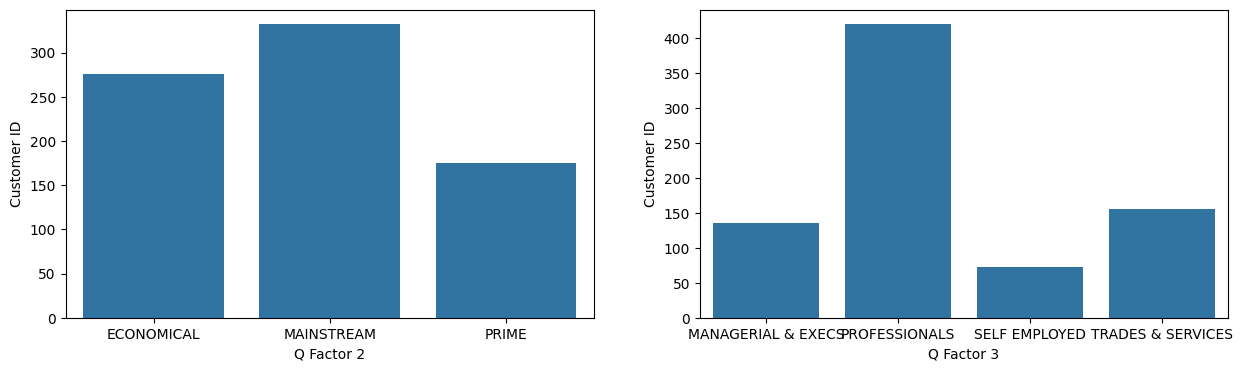

In [152]:
# Looking at composition of young couples
f,a = fa(1,2,(15,4))
for i in range(2):
    sns.barplot(young_couples.groupby(f"Q Factor {i+2}")['Customer ID'].count(), ax = a[i])

In [209]:
df[df['Q Factor 1']=='YOUNG COUPLES']

Customer ID  Campaign ID Contact Date        DOB     Q Factor 1  \
4           35185        10001   2020-06-14 1985-09-05  YOUNG COUPLES   
5           35258        10001   2020-06-09 1987-09-05  YOUNG COUPLES   
6           35191        10001   2020-06-15 1994-01-06  YOUNG COUPLES   
7           35152        10001   2020-06-09 1987-07-21  YOUNG COUPLES   
9           35169        10001   2020-06-13 1998-09-02  YOUNG COUPLES   
...           ...          ...          ...        ...            ...   
3245        45293        10038   2022-06-05 1995-07-19  YOUNG COUPLES   
3250        45307        10038   2022-06-08 1995-09-08  YOUNG COUPLES   
3254        45137        10037   2022-06-09 1999-11-17  YOUNG COUPLES   
3257        45238        10038   2022-06-13 1983-12-17  YOUNG COUPLES   
3258        45275        10038   2022-06-10 1998-01-04  YOUNG COUPLES   

      Q Factor 2          Q Factor 3  Application ID Application Date  \
4     MAINSTREAM       PROFESSIONALS           10006       2020-06-22   
5     MAINSTREAM       PROFESSIONALS           10008       2020-06-16   
6          PRIME       PROFESSIONALS           10009       2020-06-19   
7     ECONOMICAL  MANAGERIAL & EXECS           10010       2020-06-14   
9     MAINSTREAM  MANAGERIAL & EXECS           10013       2020-06-16   
...          ...                 ...             ...              ...   
3245  MAINSTREAM   TRADES & SERVICES           14083       2022-06-11   
3250  ECONOMICAL       PROFESSIONALS           14088       2022-06-18   
3254  ECONOMICAL   TRADES & SERVICES           14093       2022-06-14   
3257  ECONOMICAL       PROFESSIONALS           14096       2022-06-18   
3258  ECONOMICAL       PROFESSIONALS           14097       2022-06-10   

      Loan Amount  ...  Administration Expense  Service Expense  Clawbacked  \
4       888404.88  ...                     750              550           0   
5       950604.32  ...                     750              550           1   
6       815792.00  ...                     750              550           1   
7      1048110.00  ...                     750              550           1   
9      1025966.48  ...                     750              550           0   
...           ...  ...                     ...              ...         ...   
3245   1332825.00  ...                     550              350           0   
3250   1315392.00  ...                     550              350           0   
3254   1259368.00  ...                     850              550           0   
3257   1344389.00  ...                     550              350           0   
3258   1422840.00  ...                     550              350           0   

      Account Open Date_y   Account Close Date Close Reason  \
4                       0                    0            0   
5     2020-06-19 00:00:00  2020-07-22 00:00:00      DEFAULT   
6     2020-06-20 00:00:00  2021-04-11 00:00:00    REFINANCE   
7     2020-06-23 00:00:00  2021-02-28 00:00:00    REFINANCE   
9                       0                    0            0   
...                   ...                  ...          ...   
3245                    0                    0            0   
3250                    0                    0            0   
3254                    0                    0            0   
3257                    0                    0            0   
3258                    0                    0            0   

      open date + 12 mths Loan In Excess to Home Value Clawback Delay Weeks  
4                       0                   -448897.12            NaN    12  
5     2021-06-19 00:00:00                   -223032.48           33.0     6  
6     2021-06-20 00:00:00                   -691440.00          295.0     9  
7     2021-06-23 00:00:00                   -334719.00          250.0     4  
9                       0                   -431636.52            NaN     6  
...                   ...                          ...            ...   ...  


202.0
581.0


/var/folders/hv/zv65r5j52zgd1nc0cykq3pv00000gn/T/ipykernel_10221/1286632489.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  young_couples['Over M'] = 'N'


<Axes: xlabel='Annual Income', ylabel='Cumulative Frequency'>

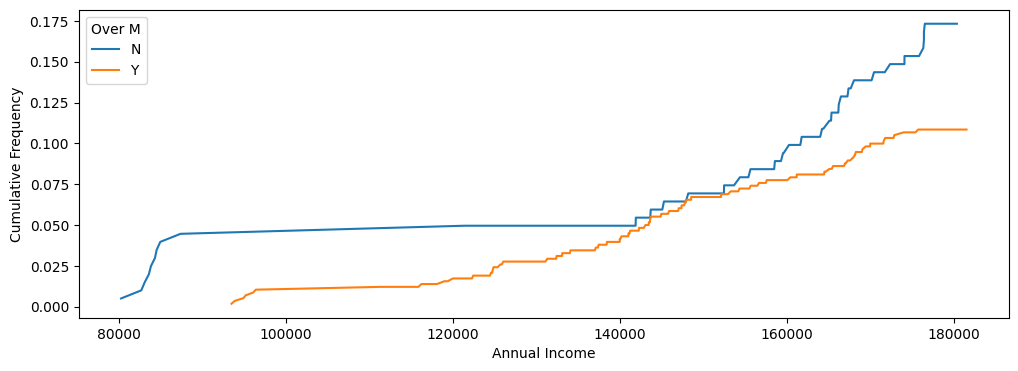

In [261]:
#Splitting young couples by loan amount
# Looking at CF of loan to LOAN amount for young couples
young_couples = df[df['Q Factor 1']=='YOUNG COUPLES']
young_couples['Over M'] = 'N'
young_couples.loc[young_couples['Loan Amount']>1000000, 'Over M'] = 'Y'

fig, ax = plt.subplots(1,1, figsize = (12,4))
cumfreq_df = young_couples[['Annual Income', 'Clawbacked', 'Over M','Loan Amount']].sort_values('Annual Income')
cumfreq_df['Cumulative Frequency'] = cumfreq_df.groupby('Over M')['Clawbacked'].cumsum().astype('float64')
count_df = young_couples.groupby(f'Over M')['Customer ID'].count().astype('float64')

for i in count_df.index:
    cumfreq_df.loc[cumfreq_df['Over M']==i,'Cumulative Frequency'] /= count_df[i]
    print(count_df[i])
sns.lineplot(cumfreq_df, x = 'Annual Income', y='Cumulative Frequency', hue='Over M')


Out of young couples, the no. of clawbacks for those who take loan amts under 1 M is more than those who take loan amts over 1 M?

<Axes: xlabel='Over M', ylabel='Clawbacked'>

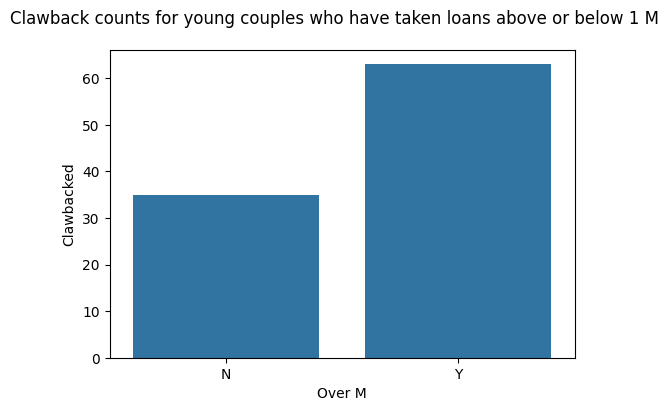

In [265]:
f,a = fa(1,1,(6,4))
f.suptitle('Clawback counts for young couples who have taken loans above or below 1 M')
sns.barplot(young_couples.groupby('Over M')['Clawbacked'].sum(), ax = a)

Maybe the no. of young couples w loan amts under 1M is larger?

<Axes: xlabel='Over M', ylabel='Customer ID'>

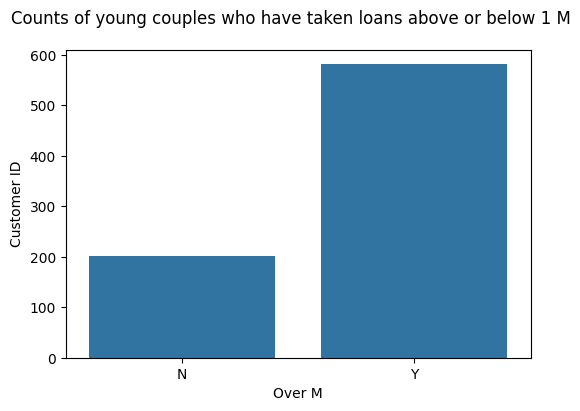

In [267]:
f,a = fa(1,1,(6,4))
f.suptitle('Counts of young couples who have taken loans above or below 1 M')
sns.barplot(young_couples.groupby('Over M')['Customer ID'].count(), ax = a)

/var/folders/hv/zv65r5j52zgd1nc0cykq3pv00000gn/T/ipykernel_10221/2738565538.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  young_couples.loc[young_couples['Loan Amount']>1000000]['Over M'] ='Over M'


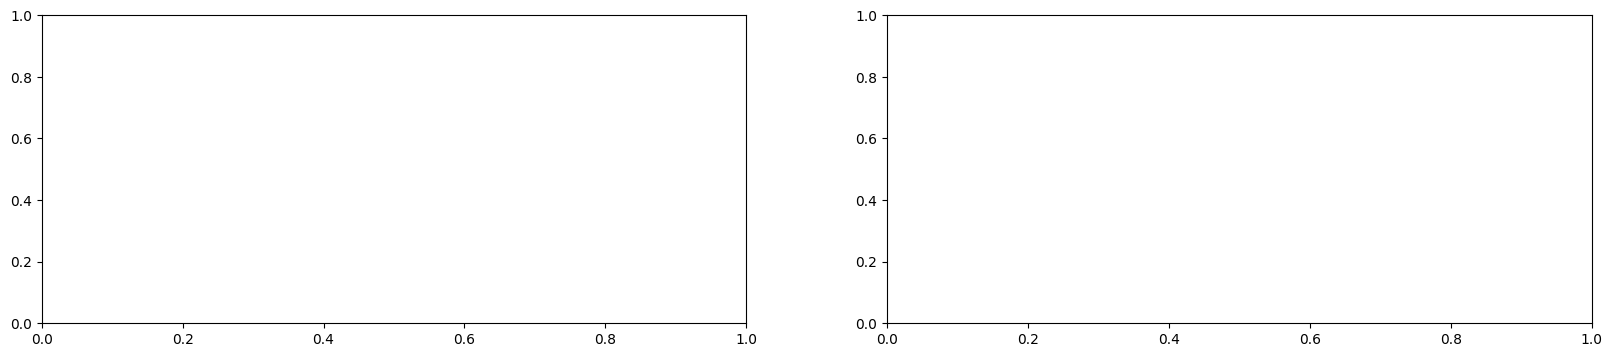

In [217]:
young_couples.loc[young_couples['Loan Amount']>1000000]['Over M'] ='Over M'

fig, ax = plt.subplots(1,2, figsize = (20,4))
cumfreq_df = young_couples[['Annual Income', 'Clawbacked', 'Over M']].sort_values('Annual Income')
cumfreq_df['Cumulative Frequency'] = cumfreq_df.groupby(f'Over M')['Clawbacked'].cumsum()
count_df = young_couples.groupby(f'Over M')['Customer ID'].count().astype('float64')

In [153]:
df['Campaign Name'].unique()

array(['Own marketing', 'TV campaign - instant approvals',
       'RiskyLending special'], dtype=object)

In [184]:
#Composition of customers from each campaign

In [183]:
df['Campaign Name'].unique()

array(['Own marketing', 'TV campaign - instant approvals',
       'RiskyLending special'], dtype=object)

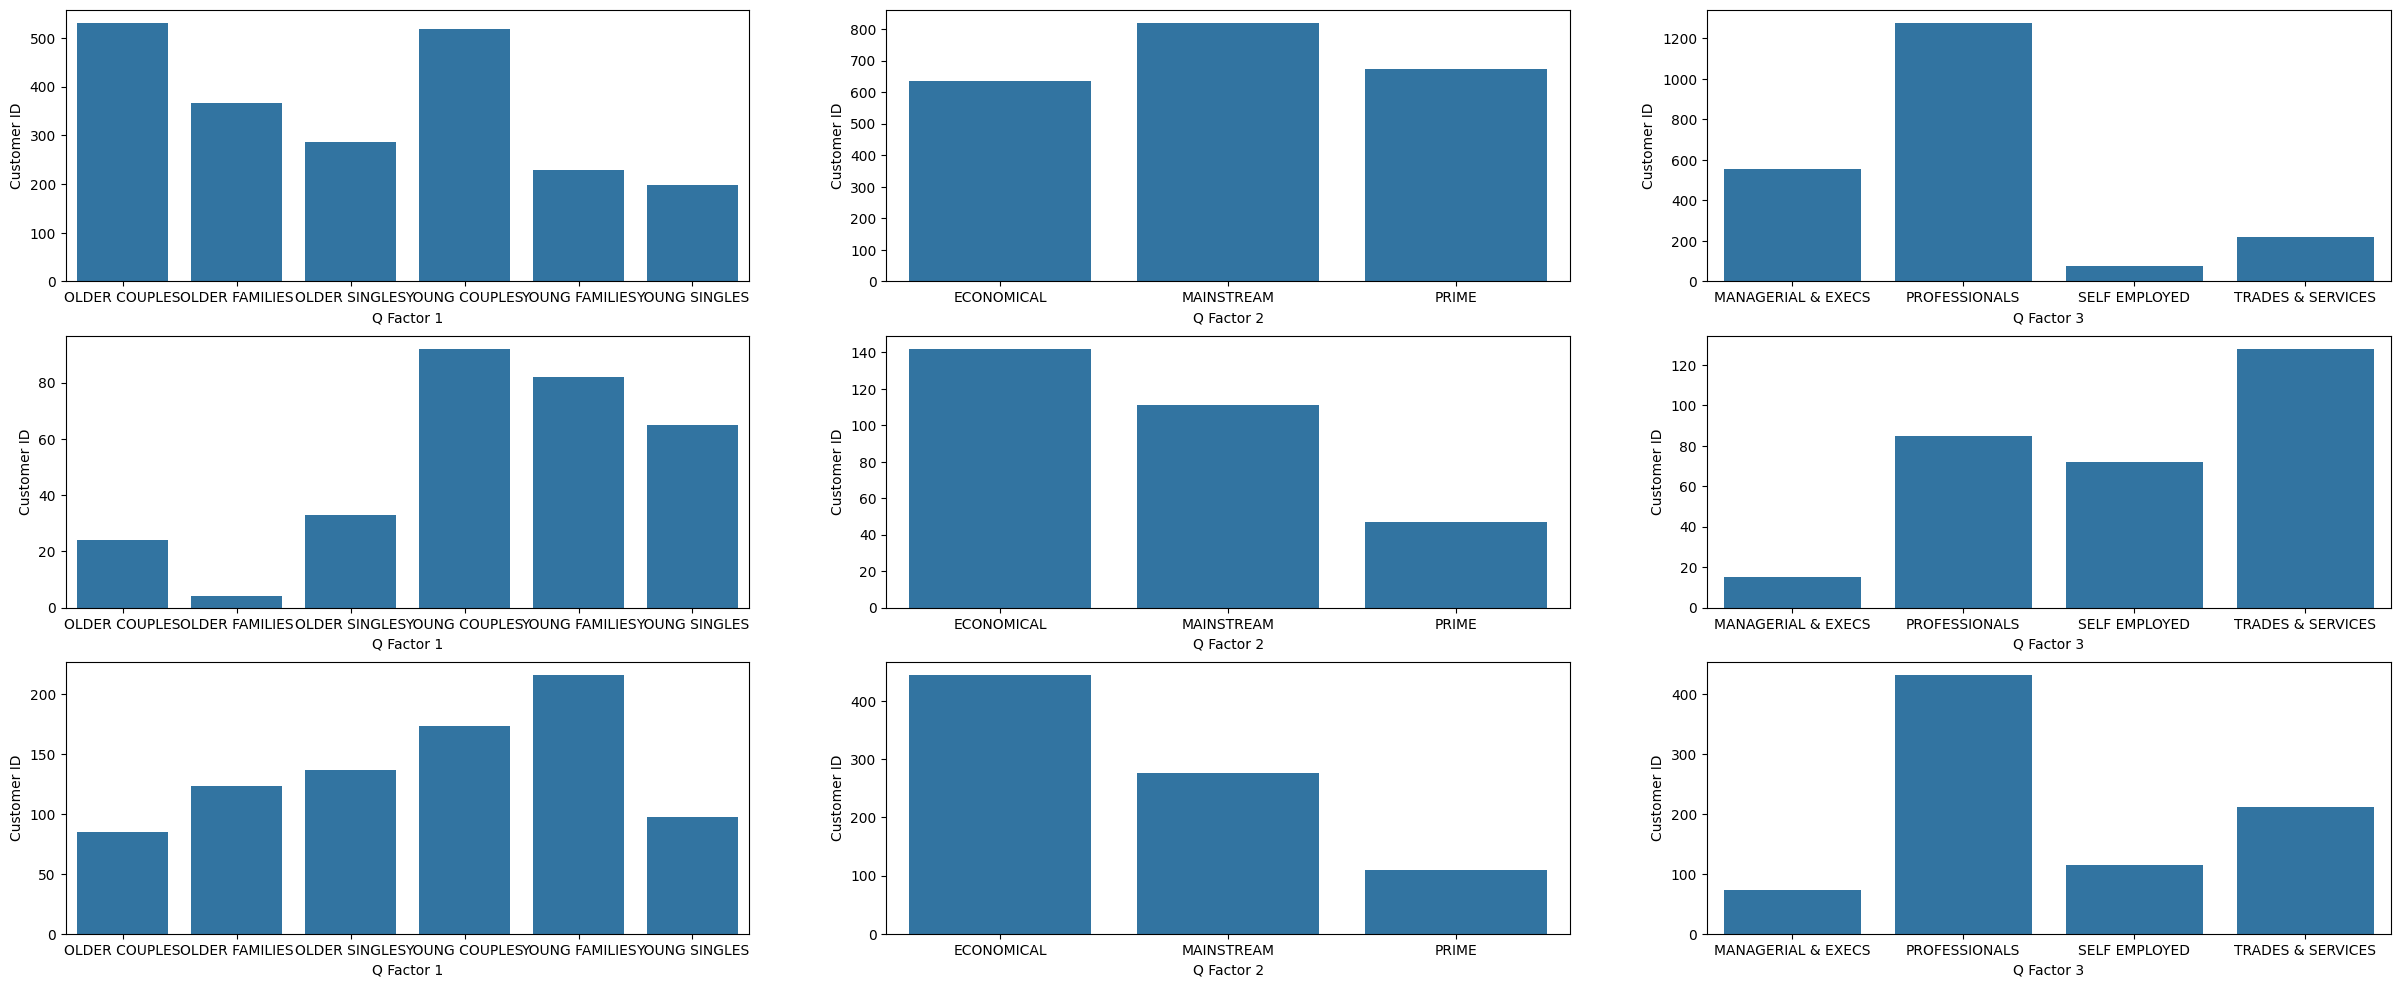

In [182]:
#Composition of customers from each campaign
f,a = fa(3,3,(30,12))
#split by campaign
for i in range(3):
    name = df['Campaign Name'].unique()[i]
    campaign = df[df['Campaign Name']==name]
    #for each campaign, plot the composition by 
    for j in range(3):
        sns.barplot(campaign.groupby(f'Q Factor {j+1}')['Customer ID'].count(), ax=a[i][j])

In [203]:
df.loc[df['Clawbacked']==1].sort_values('Account Close Date').tail()

Customer ID  Campaign ID Contact Date        DOB     Q Factor 1  \
1970        41160        10021   2021-10-15 1993-03-24  YOUNG COUPLES   
1870        41248        10022   2021-09-24 1977-12-22  YOUNG COUPLES   
2063        41844        10024   2021-11-09 1997-06-03  YOUNG COUPLES   
1864        40912        10021   2021-09-21 1987-01-18  YOUNG COUPLES   
2150        41974        10025   2021-11-15 1989-06-13  YOUNG COUPLES   

     Q Factor 2          Q Factor 3  Application ID Application Date  \
1970      PRIME       PROFESSIONALS           12494       2021-10-16   
1870      PRIME       PROFESSIONALS           12370       2021-09-24   
2063      PRIME       SELF EMPLOYED           12610       2021-11-16   
1864      PRIME  MANAGERIAL & EXECS           12362       2021-09-24   
2150      PRIME  MANAGERIAL & EXECS           12712       2021-11-20   

      Loan Amount  ...  Administration Expense  Service Expense  Clawbacked  \
1970    984378.00  ...                     750              550           1   
1870    997996.34  ...                     450              350           1   
2063   1097295.50  ...                     450              350           1   
1864    900289.57  ...                     750              550           1   
2150    891759.04  ...                     850              550           1   

      Account Open Date_y   Account Close Date Close Reason  \
1970  2021-11-29 00:00:00  2022-06-09 00:00:00    REFINANCE   
1870  2021-12-12 00:00:00  2022-06-20 00:00:00    REFINANCE   
2063  2021-12-12 00:00:00  2022-06-21 00:00:00    REFINANCE   
1864  2021-12-01 00:00:00  2022-07-08 00:00:00    REFINANCE   
2150  2022-02-09 00:00:00  2022-09-11 00:00:00    REFINANCE   

      open date + 12 mths Loan In Excess to Home Value Clawback Delay Weeks  
1970  2022-11-29 00:00:00                   -667740.00          192.0   493  
1870  2022-12-12 00:00:00                   -600431.66          190.0   471  
2063  2022-12-12 00:00:00                   -625404.50          191.0   524  
1864  2022-12-01 00:00:00                   -531116.43          219.0   471  
2150  2023-02-09 00:00:00                   -528016.96          214.0   528  

[5 rows x 30 columns]